---

# 1. Environment Setup and Data Loading

Feature description:

- competition: The level of market competition (Inverted: 0 is most competition, 1 is least competition).
- price_stability: Price stability and competitiveness
- quality_score: Customer quality, customer requirements for the product
- actual_revenue: Estimated revenue based on discounted price and rating count.
- Market_share: The product's revenue contribution to its category's total revenue.

In [41]:
# 1. Environment Setup & Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from IPython.display import display

# 1.1. Load data
file_path = 'amazon.csv'
try:
    df = pd.read_csv(file_path)
    print("File loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at path: {file_path}")

# 1.2. Drop unused columns
cols_to_drop = [
    'about_product', 'user_id', 'user_name', 'review_id', 'review_title', 
    'review_content', 'img_link', 'product_link', 'product_name'
]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
print(f"Dropped {len(cols_to_drop)} unused columns.")
print(f"Current columns: {df.columns.tolist()}")

# 1.3. Clean text columns (Remove symbols)
for col in ['discounted_price', 'actual_price']:
    df[col] = df[col].str.replace('[₹,]', '', regex=True)

df['discount_percentage'] = df['discount_percentage'].str.replace('%', '', regex=False)
df['rating_count'] = df['rating_count'].astype(str).str.replace(',', '', regex=False)

# 1.4. Convert to numeric types
cols_to_numeric = ['discounted_price', 'actual_price', 'rating_count', 'discount_percentage', 'rating']
df[cols_to_numeric] = df[cols_to_numeric].apply(pd.to_numeric, errors='coerce')

print("Data loaded and basic cleaning done.")

File loaded successfully.
Dropped 9 unused columns.
Current columns: ['product_id', 'category', 'discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count']
Data loaded and basic cleaning done.


In [42]:
# 2. Data Integrity Check

# 2.1. Handle missing data
initial_rows = df.shape[0]
df.dropna(subset=['rating', 'rating_count'], inplace=True)

# 2.2. Filter invalid data (Rating = 0)
df = df[df['rating'] != 0].copy()

rows_dropped = initial_rows - df.shape[0]
print(f"Dropped {rows_dropped} rows with missing or invalid data.")

Dropped 3 rows with missing or invalid data.


In [43]:
# Calculate temporary revenue for statistics
df['temp_revenue'] = df['discounted_price'] * df['rating_count']

# Statistics by Category: Product Count and Average Revenue
category_summary_df = df.groupby('category').agg(
    Product_count=('category', 'count'),
    Average_revenue=('temp_revenue', 'mean')
).reset_index()

# Rename columns
category_summary_df.columns = ['Category name', 'Product count', 'Average revenue']

# Remove temporary column in main dataframe to keep data clean
df.drop(columns=['temp_revenue'], inplace=True)

# Display results
display(category_summary_df)

Category name  Product count  \
0    Car&Motorbike|CarAccessories|InteriorAccessori...              1   
1    Computers&Accessories|Accessories&Peripherals|...              2   
2    Computers&Accessories|Accessories&Peripherals|...              1   
3    Computers&Accessories|Accessories&Peripherals|...              2   
4    Computers&Accessories|Accessories&Peripherals|...              2   
..                                                 ...            ...   
206  OfficeProducts|OfficePaperProducts|Paper|Stati...              2   
207  OfficeProducts|OfficePaperProducts|Paper|Stati...              2   
208  OfficeProducts|OfficePaperProducts|Paper|Stati...              2   
209  OfficeProducts|OfficePaperProducts|Paper|Stati...              3   
210  Toys&Games|Arts&Crafts|Drawing&PaintingSupplie...              1   

     Average revenue  
0       2.615002e+06  
1       7.653520e+05  
2       4.687078e+06  
3       7.381788e+06  
4       4.806702e+06  
..               ...  
206     4.733000e+05  
207     6.834150e+05  
208     1.590610e+06  
209     7.898883e+05  
210     2.380050e+06  

[211 rows x 3 columns]

In [44]:
# 3. Feature Engineering

# 3.1. Basic Metrics
df['actual_revenue'] = df['discounted_price'] * df['rating_count']
df['discount_abs_diff'] = df['actual_price'] - df['discounted_price']
df['price_stability'] = 1 - (df['discount_percentage'] / 100)
df['quality_score'] = (df['rating'] ** 2) * np.log1p(df['rating_count']) 

# 3.2. Category-based Metrics
cat_group = df.groupby('category')

# Competition & Market Share
df['competition'] = cat_group['product_id'].transform('count')
df['category_total_revenue'] = cat_group['actual_revenue'].transform('sum')

df['Market_share'] = df['actual_revenue'].div(df['category_total_revenue']).fillna(0)

# 3.3. Relative Positioning (0-1 Scaling within Category)
def robust_minmax(x):
    if x.min() == x.max(): return 0.5
    return (x - x.min()) / (x.max() - x.min())

def robust_log_minmax(x):
    """Applies Log1p first to handle high-value outliers, then MinMax."""
    log_x = np.log1p(x)
    if log_x.min() == log_x.max(): return 0.5
    return (log_x - log_x.min()) / (log_x.max() - log_x.min())

# Apply LOG scaling to Price (CRITICAL FIX)
df['relative_price_position'] = cat_group['discounted_price'].transform(robust_log_minmax)

# Apply standard scaling to Rating & Discount
df['rating_standing'] = cat_group['rating'].transform(robust_minmax)
df['discount_standing'] = cat_group['discount_percentage'].transform(robust_minmax)

# 3.4. Value for Money (Price per Rating Point)
temp_ppr = df['discounted_price'] / df['rating'].replace(0, 1e-5)

# Apply LOG scaling here too (Since price range varies wildly)
df['price_per_rating_point'] = temp_ppr.groupby(df['category']).transform(robust_log_minmax)

print("Feature Engineering optimized with Log-Scaling.")
display(df.head())

Feature Engineering optimized with Log-Scaling.


product_id                                           category  \
0  B07JW9H4J1  Computers&Accessories|Accessories&Peripherals|...   
1  B098NS6PVG  Computers&Accessories|Accessories&Peripherals|...   
2  B096MSW6CT  Computers&Accessories|Accessories&Peripherals|...   
3  B08HDJ86NZ  Computers&Accessories|Accessories&Peripherals|...   
4  B08CF3B7N1  Computers&Accessories|Accessories&Peripherals|...   

   discounted_price  actual_price  discount_percentage  rating  rating_count  \
0             399.0        1099.0                   64     4.2       24269.0   
1             199.0         349.0                   43     4.0       43994.0   
2             199.0        1899.0                   90     3.9        7928.0   
3             329.0         699.0                   53     4.2       94363.0   
4             154.0         399.0                   61     4.2       16905.0   

   actual_revenue  discount_abs_diff  price_stability  quality_score  \
0       9683331.0              700.0             0.36     178.111015   
1       8754806.0              150.0             0.57     171.069300   
2       1577672.0             1700.0             0.10     136.559672   
3      31045427.0              370.0             0.47     202.064699   
4       2603370.0              245.0             0.39     171.732877   

   competition  category_total_revenue  Market_share  relative_price_position  \
0          231            1.171594e+09      0.008265                 0.580176   
1          231            1.171594e+09      0.007473                 0.370265   
2          231            1.171594e+09      0.001347                 0.370265   
3          231            1.171594e+09      0.026498                 0.521919   
4          231            1.171594e+09      0.002222                 0.293073   

   rating_standing  discount_standing  price_per_rating_point  
0         0.529412           0.711111                0.577765  
1         0.411765           0.477778                0.375995  
2         0.352941           1.000000                0.383853  
3         0.529412           0.588889                0.517406  
4         0.529412           0.677778                0.281624

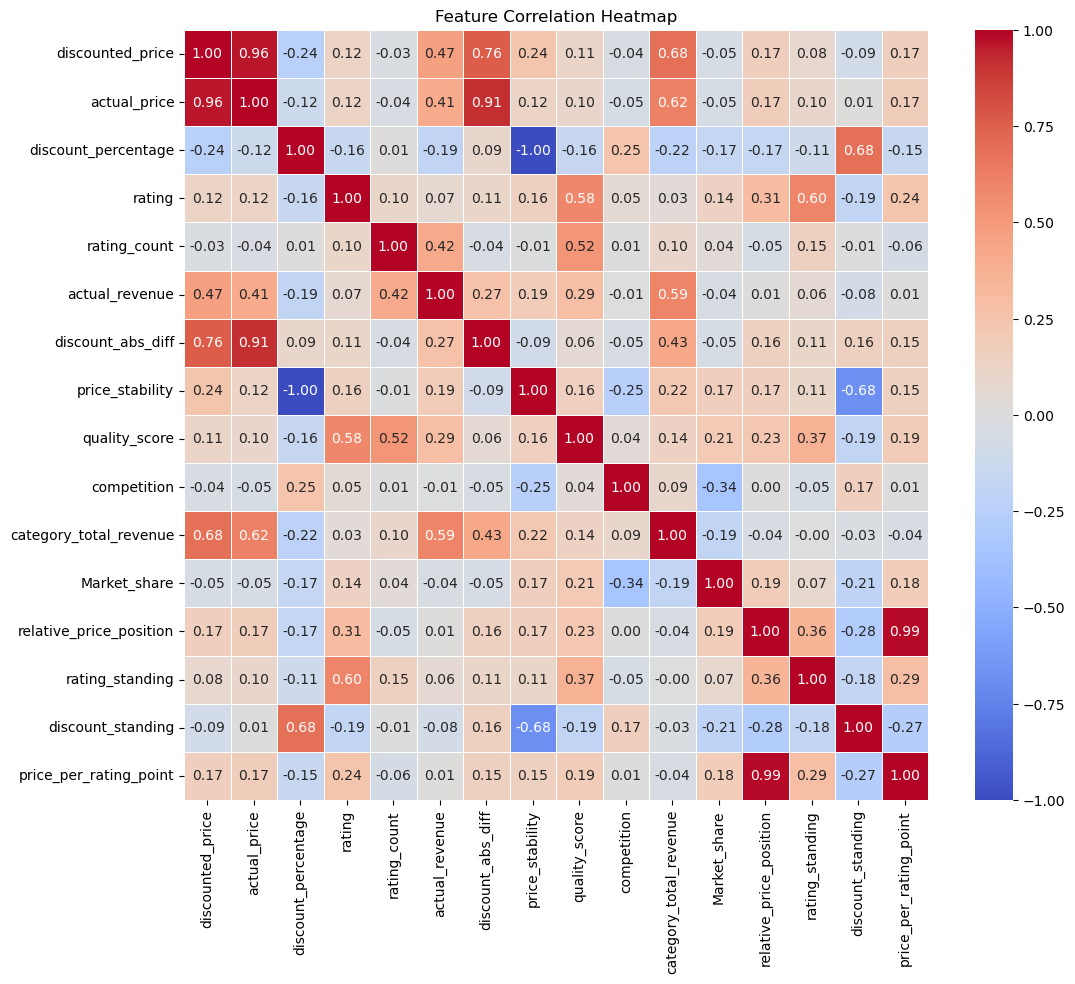

In [45]:
# Correlation Matrix Heatmap
plt.figure(figsize=(12, 10))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

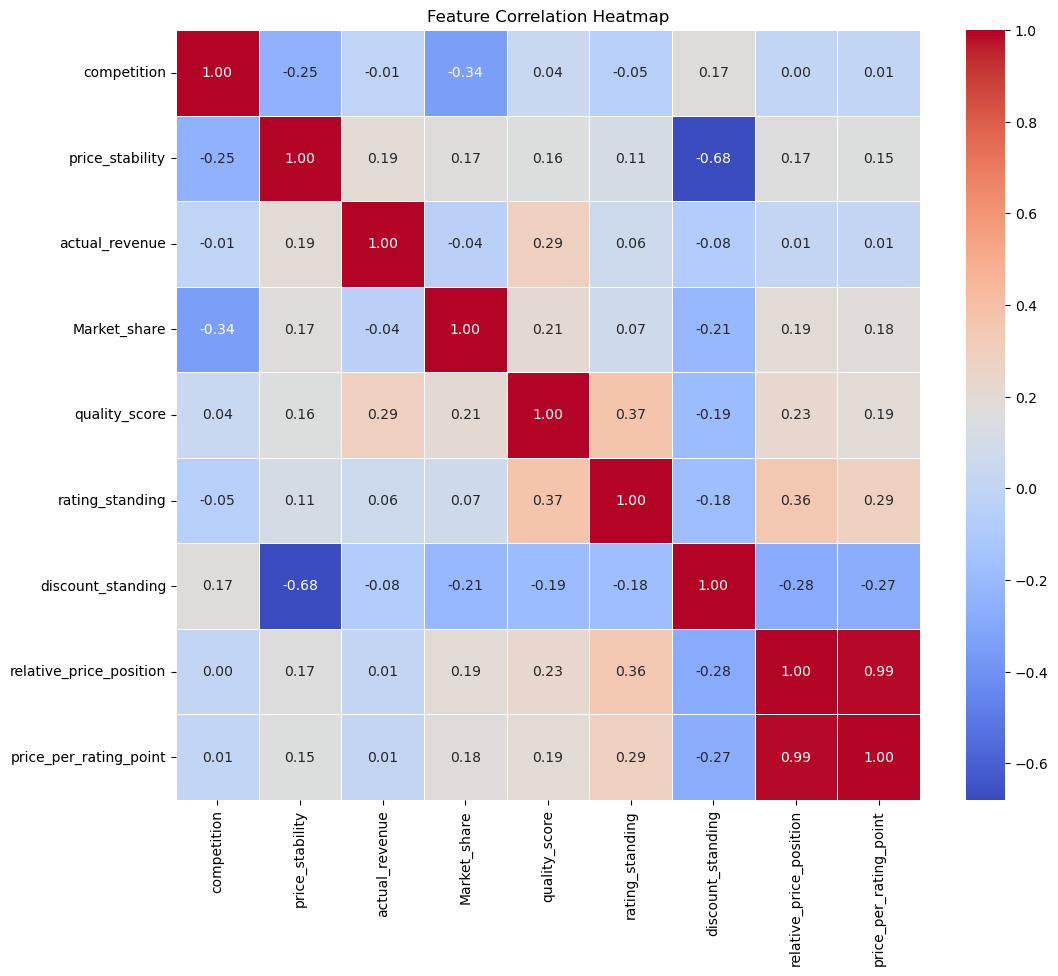

In [46]:
# Correlation Matrix Heatmap
plt.figure(figsize=(12, 10))
numeric_df = df[['competition', 'price_stability', 'actual_revenue', 'Market_share', 'quality_score', 'rating_standing', 'discount_standing', 'relative_price_position', 'price_per_rating_point']]
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

In [47]:
# 4. Normalization

scaler = MinMaxScaler()
cols_to_norm = ['quality_score', 'actual_revenue', 'discount_abs_diff', 'competition']

df[cols_to_norm] = scaler.fit_transform(df[cols_to_norm])

# Invert competition: 0 is most competition (highest count), 1 is least competition (lowest count)
df['competition'] = 1 - df['competition']

print("Normalization and Reordering finished.")
print(f"Final DataFrame Shape: {df.shape[0]} rows, {df.shape[1]} columns.")

display(df.head())

Normalization and Reordering finished.
Final DataFrame Shape: 1462 rows, 18 columns.


product_id                                           category  \
0  B07JW9H4J1  Computers&Accessories|Accessories&Peripherals|...   
1  B098NS6PVG  Computers&Accessories|Accessories&Peripherals|...   
2  B096MSW6CT  Computers&Accessories|Accessories&Peripherals|...   
3  B08HDJ86NZ  Computers&Accessories|Accessories&Peripherals|...   
4  B08CF3B7N1  Computers&Accessories|Accessories&Peripherals|...   

   discounted_price  actual_price  discount_percentage  rating  rating_count  \
0             399.0        1099.0                   64     4.2       24269.0   
1             199.0         349.0                   43     4.0       43994.0   
2             199.0        1899.0                   90     3.9        7928.0   
3             329.0         699.0                   53     4.2       94363.0   
4             154.0         399.0                   61     4.2       16905.0   

   actual_revenue  discount_abs_diff  price_stability  quality_score  \
0        0.003630           0.011307             0.36       0.704453   
1        0.003282           0.002423             0.57       0.675897   
2        0.000591           0.027459             0.10       0.535954   
3        0.011639           0.005976             0.47       0.801590   
4        0.000976           0.003957             0.39       0.678588   

   competition  category_total_revenue  Market_share  relative_price_position  \
0          0.0            1.171594e+09      0.008265                 0.580176   
1          0.0            1.171594e+09      0.007473                 0.370265   
2          0.0            1.171594e+09      0.001347                 0.370265   
3          0.0            1.171594e+09      0.026498                 0.521919   
4          0.0            1.171594e+09      0.002222                 0.293073   

   rating_standing  discount_standing  price_per_rating_point  
0         0.529412           0.711111                0.577765  
1         0.411765           0.477778                0.375995  
2         0.352941           1.000000                0.383853  
3         0.529412           0.588889                0.517406  
4         0.529412           0.677778                0.281624

In [48]:
# 5. Basic Statistics Summary
print(f"Total Products: {df.shape[0]}")
print(f"Total Categories: {df['category'].nunique()}")
print(f"Average Rating: {df['rating'].mean():.2f}")
print(f"Average Discount: {df['discount_percentage'].mean():.1f}%")


Total Products: 1462
Total Categories: 211
Average Rating: 4.10
Average Discount: 47.7%


---------------------------------------------

# 2. Assign labels to the model (unsupervised learning)

## K-MEANS CLUSTERING (Refactored for Clarity)

### Step 1: Imports & Setup

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from kneed import KneeLocator

print("K-Means libraries imported successfully.")

K-Means libraries imported successfully.


### Step 2: Feature Selection and Scaling

In [50]:
# Select the features for clustering
investment_features = [
    'relative_price_position',  
    'quality_score',            
    'discount_standing',        
    'Market_share',             
    'competition'               
]
features_data = df[investment_features]

# Scale the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features_data)

print("1. Features selected and scaled successfully.")
print(f"Data shape for clustering: {scaled_data.shape}")

1. Features selected and scaled successfully.
Data shape for clustering: (1462, 5)


### Step 3: Determine the Optimal Number of Clusters (K)

In [51]:
# Optimized: K-Means Optimal K Finder (Elbow + Silhouette + Business Logic)
def find_optimal_k(scaled_data, k_min=2, k_max=11):
    inertia, silhouette_scores = [], []
    k_range = list(range(k_min, k_max))
    
    print(f"Analyzing K from {k_min} to {k_max - 1}...")
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(scaled_data)
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))
        
    # Metric Calculations
    elbow_k = KneeLocator(k_range, inertia, curve="convex", direction="decreasing").elbow
    best_sil_k = k_range[np.argmax(silhouette_scores)]
    max_sil_score = max(silhouette_scores)
    
    print(f"Suggested K: Elbow={elbow_k}, Silhouette={best_sil_k} ({max_sil_score:.4f})")
    
    # Business Logic: Prefer K in [3, 6] if score is competitive (>90% of max)
    business_range = range(3, 7)
    optimal_k, method = best_sil_k, "Silhouette (Global)"

    if best_sil_k not in business_range:
        scores_in_range = {k: s for k, s in zip(k_range, silhouette_scores) if k in business_range}
        if scores_in_range:
            best_biz_k = max(scores_in_range, key=scores_in_range.get)
            if scores_in_range[best_biz_k] >= max_sil_score * 0.9:
                optimal_k, method = best_biz_k, "Silhouette (Business)"
            elif elbow_k in business_range:
                optimal_k, method = elbow_k, "Elbow (Fallback)"
            else:
                optimal_k, method = 4, "Default (4)"
        else:
             optimal_k, method = 4, "Default (4)"

    print(f"-> Selected k={optimal_k} ({method})")
    return optimal_k, k_range, inertia, k_range, silhouette_scores

# Visualization
def visualize_optimal_k(optimal_k, k_range, inertia, sil_range, sil_scores):
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    ax1.set_xlabel('Clusters (k)')
    ax1.set_ylabel('Inertia', color='tab:blue')
    ax1.plot(k_range, inertia, marker='o', color='tab:blue')
    ax1.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Silhouette', color='tab:orange')
    ax2.plot(sil_range, sil_scores, marker='s', linestyle='--', color='tab:orange')
    
    plt.title('Optimal k: Elbow & Silhouette')
    plt.show()

Analyzing K from 2 to 10...
Suggested K: Elbow=5, Silhouette=4 (0.3104)
-> Selected k=4 (Silhouette (Global))


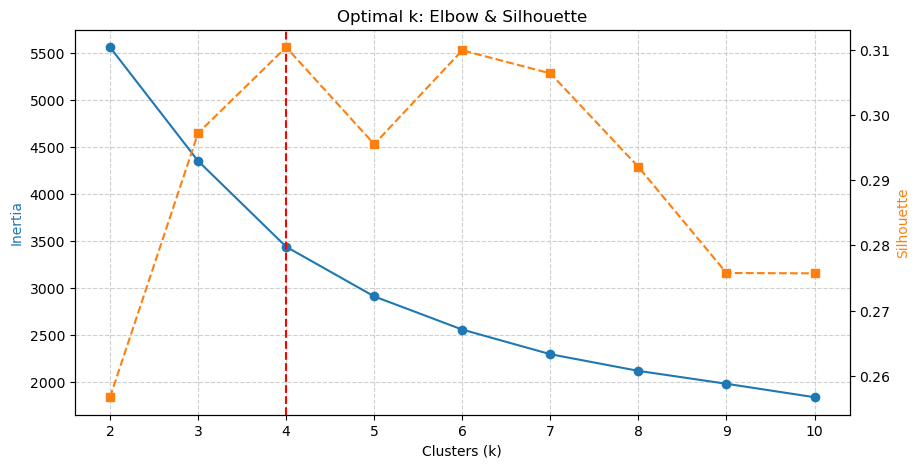

In [52]:
# Execute the functions to find and visualize optimal K
optimal_k, k_range_elbow, inertia_values, k_range_sil, silhouette_values = find_optimal_k(scaled_data)
visualize_optimal_k(optimal_k, k_range_elbow, inertia_values, k_range_sil, silhouette_values)

### Step 4: Train K-Means Model and Analyze Clusters

In [53]:
# Train the model with the optimal k and analyze the resulting clusters
def analyze_clusters(df, features, scaler, n_clusters):
    # Re-fit the scaler and transform the data to ensure consistency
    scaled_data = scaler.fit_transform(df[features])
    
    # Train the K-Means model
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df['kmean_cluster'] = kmeans.fit_predict(scaled_data)
    print(f"K-Means model trained with k={n_clusters}.")

    # Analyze cluster characteristics by their mean feature values
    analysis = df.groupby('kmean_cluster')[features].mean()
    
    print("Cluster Characteristics ")
    display(analysis)
    
    return df, kmeans, analysis

# Run the analysis
df_clustered, kmeans_model, cluster_analysis = analyze_clusters(df, investment_features, StandardScaler(), optimal_k)

K-Means model trained with k=4.
Cluster Characteristics 


relative_price_position  quality_score  discount_standing  \
kmean_cluster                                                              
0                             0.483014       0.564136           0.658009   
1                             0.629662       0.606786           0.400687   
2                             0.273374       0.431851           0.776376   
3                             0.594470       0.640144           0.390039   

               Market_share  competition  
kmean_cluster                             
0                  0.004329     0.000000  
1                  0.858214     0.995090  
2                  0.047805     0.895134  
3                  0.102172     0.881103

### Step 5: Visualize Clustering Results

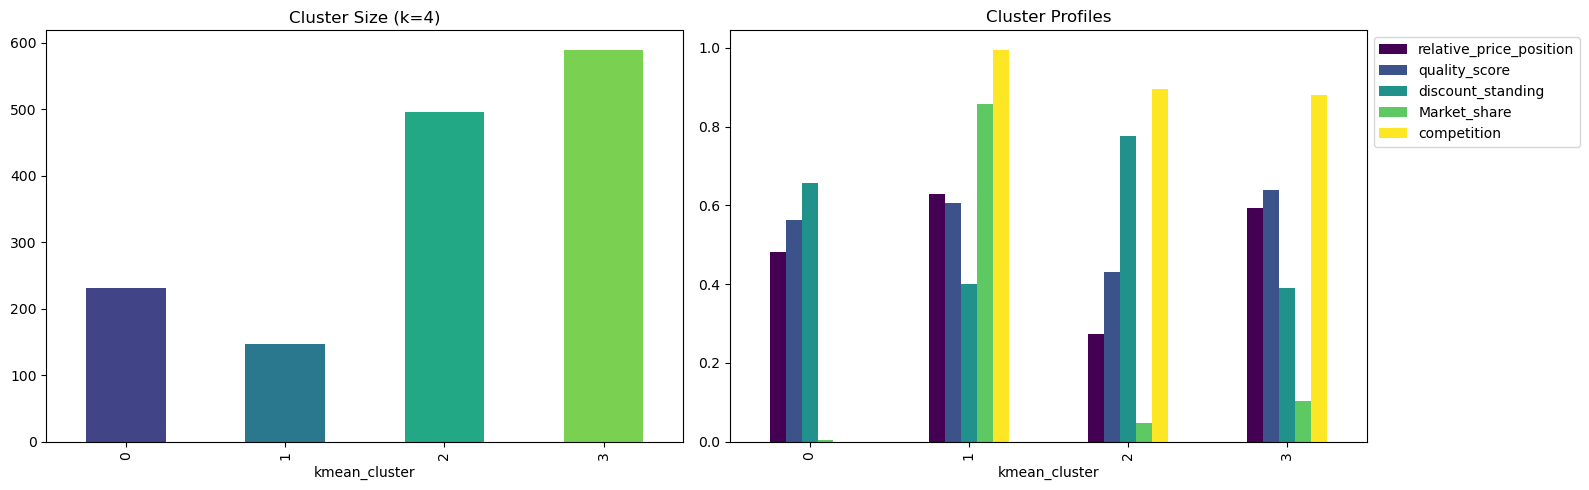

product_id  kmean_cluster  relative_price_position  quality_score  \
0  B07JW9H4J1              0                 0.580176       0.704453   
1  B098NS6PVG              0                 0.370265       0.675897   
2  B096MSW6CT              0                 0.370265       0.535954   
3  B08HDJ86NZ              0                 0.521919       0.801590   
4  B08CF3B7N1              0                 0.293073       0.678588   

   discount_standing  Market_share  competition  
0           0.711111      0.008265          0.0  
1           0.477778      0.007473          0.0  
2           1.000000      0.001347          0.0  
3           0.588889      0.026498          0.0  
4           0.677778      0.002222          0.0

In [54]:
# Refactored Visualization
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from IPython.display import display

def visualize_cluster_dashboard(df, n_clusters, analysis, features, scaler):
    # 1. PCA Setup
    pca_data = PCA(n_components=2).fit_transform(scaler.fit_transform(df[features]))
    df['pca1'], df['pca2'] = pca_data[:, 0], pca_data[:, 1]

    # 2. Static Overview
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    # Cluster Size
    df['kmean_cluster'].value_counts().sort_index().plot(
        kind='bar', color=sns.color_palette("viridis", n_clusters), ax=ax1
    )
    ax1.set_title(f'Cluster Size (k={n_clusters})')
    
    # Feature Profile
    analysis[features].plot(kind='bar', ax=ax2, colormap='viridis')
    ax2.set_title('Cluster Profiles')
    ax2.legend(bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()

    # 3. Interactive PCA
    fig = px.scatter(
        df, x='pca1', y='pca2', color=df['kmean_cluster'].astype(str),
        hover_data=['product_id', 'category', 'quality_score'],
        title='Cluster PCA Map',
        template='plotly_white'
    )
    fig.update_layout(legend_title='Cluster', height=500)
    fig.show()

    # 4. Preview
    display(df[['product_id', 'kmean_cluster'] + features].head())

# Execute
visualize_cluster_dashboard(df_clustered, optimal_k, cluster_analysis, investment_features, StandardScaler())

### Step 6: Interactive 3D Cluster Visualization

In [55]:
print("Generating interactive 3D K-Means cluster visualization...")

# Create temporary metric: less_competition
df['less_competition'] = 1 / df.groupby('category')['product_id'].transform('count')

# Step 3: Create the Interactive 3D Scatter Plot
fig = px.scatter_3d(
    df,
    x='less_competition',                 # CORRECTED: Use the new 'less_competition' column
    y='price_stability',
    z='quality_score',
    color='kmean_cluster',
    size='Market_share',                  # Feature 4: Size represents Market Share
    size_max=20,                          # Adjust max size for better visibility
    hover_name='product_id',              # IMPROVEMENT: Show product_id as the tooltip title
    title='Interactive 3D K-Means Cluster Visualization (5 Features)',
    labels={
        'price_stability': 'Price Stability', 
        'quality_score': 'Quality Score',
        'Market_share': 'Market Share',
        'less_competition': 'Less Competition',    # CORRECTED: Key is 'less_competition'
        'kmean_cluster': 'Cluster',
        'rating': 'Rating'
    },
    hover_data=['rating', 'less_competition'], # CORRECTED: Use 'less_competition' here as well
    template='plotly_white'               # Use a clean, professional template
)

# Step 4: Customize Layout and Appearance
fig.update_traces(
    marker=dict(
        opacity=0.8,
        line=dict(width=0) # IMPROVEMENT: Remove marker border for cleaner 3D look
    )
)


Generating interactive 3D K-Means cluster visualization...


In [56]:
all_cols = df.columns.tolist()
cols_to_move = ['pca1', 'pca2', 'kmean_cluster']
new_order = [col for col in all_cols if col not in cols_to_move] + cols_to_move
df = df[new_order]
display(df.head())

product_id                                           category  \
0  B07JW9H4J1  Computers&Accessories|Accessories&Peripherals|...   
1  B098NS6PVG  Computers&Accessories|Accessories&Peripherals|...   
2  B096MSW6CT  Computers&Accessories|Accessories&Peripherals|...   
3  B08HDJ86NZ  Computers&Accessories|Accessories&Peripherals|...   
4  B08CF3B7N1  Computers&Accessories|Accessories&Peripherals|...   

   discounted_price  actual_price  discount_percentage  rating  rating_count  \
0             399.0        1099.0                   64     4.2       24269.0   
1             199.0         349.0                   43     4.0       43994.0   
2             199.0        1899.0                   90     3.9        7928.0   
3             329.0         699.0                   53     4.2       94363.0   
4             154.0         399.0                   61     4.2       16905.0   

   actual_revenue  discount_abs_diff  price_stability  ...  \
0        0.003630           0.011307             0.36  ...   
1        0.003282           0.002423             0.57  ...   
2        0.000591           0.027459             0.10  ...   
3        0.011639           0.005976             0.47  ...   
4        0.000976           0.003957             0.39  ...   

   category_total_revenue  Market_share  relative_price_position  \
0            1.171594e+09      0.008265                 0.580176   
1            1.171594e+09      0.007473                 0.370265   
2            1.171594e+09      0.001347                 0.370265   
3            1.171594e+09      0.026498                 0.521919   
4            1.171594e+09      0.002222                 0.293073   

   rating_standing  discount_standing  price_per_rating_point  \
0         0.529412           0.711111                0.577765   
1         0.411765           0.477778                0.375995   
2         0.352941           1.000000                0.383853   
3         0.529412           0.588889                0.517406   
4         0.529412           0.677778                0.281624   

   less_competition      pca1      pca2  kmean_cluster  
0          0.004329 -0.736361 -2.253837              0  
1          0.004329 -0.729978 -1.965466              0  
2          0.004329 -1.943352 -1.432697              0  
3          0.004329 -0.351179 -2.449032              0  
4          0.004329 -1.180044 -1.809014              0  

[5 rows x 22 columns]

### Step 7: Cluster Analysis

In [57]:
# Calculate counts of categories and products per cluster
cluster_counts = df_clustered.groupby('kmean_cluster').agg({
    'category': 'nunique',
    'product_id': 'count'
}).rename(columns={'category': 'Category Count', 'product_id': 'Product Count'})

# Merge with the existing cluster_analysis (feature means)
final_summary = cluster_analysis.merge(cluster_counts, left_index=True, right_index=True)

display(final_summary)

relative_price_position  quality_score  discount_standing  \
kmean_cluster                                                              
0                             0.483014       0.564136           0.658009   
1                             0.629662       0.606786           0.400687   
2                             0.273374       0.431851           0.776376   
3                             0.594470       0.640144           0.390039   

               Market_share  competition  Category Count  Product Count  
kmean_cluster                                                            
0                  0.004329     0.000000               1            231  
1                  0.858214     0.995090             145            147  
2                  0.047805     0.895134             116            495  
3                  0.102172     0.881103             100            589

#### Index Analysis

**1. Cluster 0: Isolated / Niche Group**
* **Metrics:** `Market_share` (~0.004) and `competition` (0.0) are negligible. `Discount_standing` (0.66) remains high.
* **Assessment:** Products operate in a niche market with zero competition but lack significant scale. Sales performance is minimal despite high discount levels, indicating low market demand.

**2. Cluster 1: Market Leaders**
* **Metrics:** `Market_share` (0.86) and `competition` (0.99) are at their peak. `Relative_price_position` (0.63) and `Quality_score` (0.61) indicate a premium positioning.
* **Assessment:** The dominant group commanding the market. Strong intrinsic value and brand equity sustain high sales volume with minimal reliance on promotions (`Discount`: 0.40).

**3. Cluster 2: Budget Segment**
* **Metrics:** Lowest `Relative_price_position` (0.27) and `Quality_score` (0.43). `Discount_standing` (0.78) is the highest across all clusters.
* **Assessment:** Competition is driven primarily by low pricing and aggressive discounting. However, the low `Market_share` (0.05) suggests that deep price cuts are ineffective at capturing significant share, resulting in poor investment efficiency.

**4. Cluster 3: High-Potential Challengers**
* **Metrics:** Achieves the highest `Quality_score` (0.64). `Relative_price_position` (0.59) aligns with the premium tier. `Discount_standing` (0.39) is the lowest.
* **Assessment:** Products possess superior quality but have not yet achieved a commensurate `Market_share` (0.10). This group represents the highest growth potential if market penetration can be improved.

------------

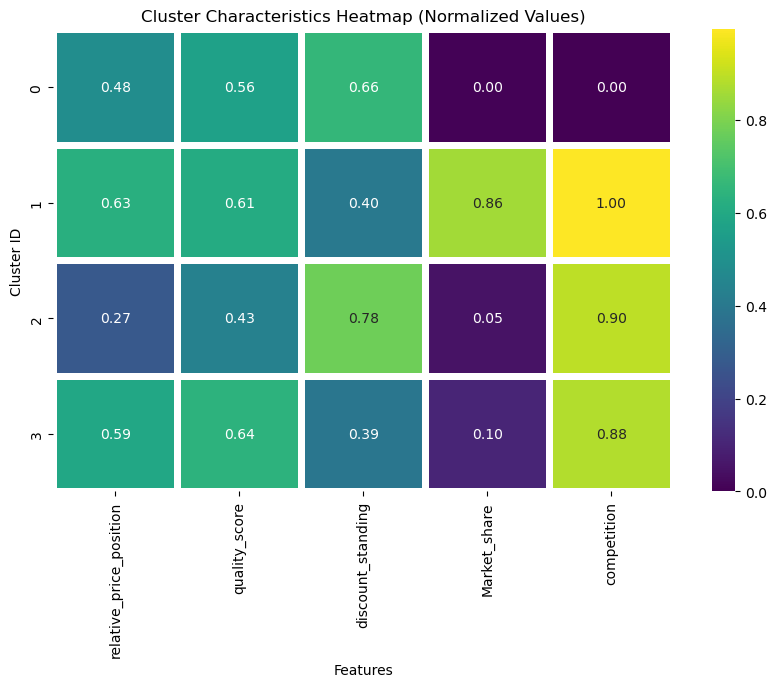

In [58]:
# Heatmap Visualization of Cluster Metrics
metric_cols = ['relative_price_position', 'quality_score', 'discount_standing', 'Market_share', 'competition']
cluster_means = df_clustered.groupby('kmean_cluster')[metric_cols].mean()
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means, annot=True, fmt='.2f', cmap='viridis', linewidths=5)
plt.title('Cluster Characteristics Heatmap (Normalized Values)') # Đổi tên tiêu đề
plt.ylabel('Cluster ID')
plt.xlabel('Features')
plt.show()

#### Heatmap Analysis

* **Cluster 0 (Niche):** An isolated group with zero competition or market share, relying passively on moderately high discounts.
* **Cluster 1 (Leader):** The market dominator with premium positioning (high price & quality), commanding the vast majority of share (0.86) without deep discounting.
* **Cluster 2 (Budget):** A low-cost, low-quality segment that fails to gain traction despite employing aggressive, maximum-level promotions (0.78).
* **Cluster 3 (Challenger):** A high-potential competitor boasting the highest quality score (0.64) and premium positioning, yet still struggling to achieve a sales breakthrough.
-----

In [59]:
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
import pandas as pd

def create_optimized_radar_chart(cluster_analysis, features):
    df_normalized = cluster_analysis[features]

    fig = go.Figure()
    categories = features if isinstance(features, list) else features.tolist()
    
    for cluster_id in df_normalized.index:
        r_values = df_normalized.loc[cluster_id].tolist() + [df_normalized.loc[cluster_id].values[0]]
        theta_values = categories + [categories[0]]
        
        # Actual values for tooltips
        real_values = cluster_analysis.loc[cluster_id, features].tolist() + [cluster_analysis.loc[cluster_id, features].values[0]]
        hover_text = [f"{f}: {v:,.2f}" for f, v in zip(theta_values, real_values)]
        
        fig.add_trace(go.Scatterpolar(
            r=r_values, 
            theta=theta_values,
            fill='toself', 
            name=f'Cluster {cluster_id}',
            text=hover_text, 
            hoverinfo='text+name'
        ))

    fig.update_layout(
      polar=dict(radialaxis=dict(visible=True, range=[0, 1.05])),
      title="Cluster Comparison Radar Chart (Normalized)",
      height=600
    )
    fig.show()

create_optimized_radar_chart(cluster_analysis, investment_features)


#### Radar Chart Analysis

* **Cluster 0 (Skewed Triangle):** The chart retracts entirely towards the left (product attributes) while missing the right side (market metrics), indicating a complete disconnection from the competitive environment.
* **Cluster 1 (Expansive Polygon):** The shape is full and covers the largest area, confirming a robust balance between intrinsic product strength and market dominance.
* **Cluster 2 (Arrowhead):** The chart distorts into a sharp point oriented towards `Discount` and `Competition`, reflecting a critical imbalance driven by a reliance on price cuts to survive.
* **Cluster 3 (Kite):** The shape peaks at `Quality` and extends towards `Price/Competition` (similar to Cluster 1) but collapses inward at `Market_share`, illustrating a strong challenger that lacks market penetration.
-----

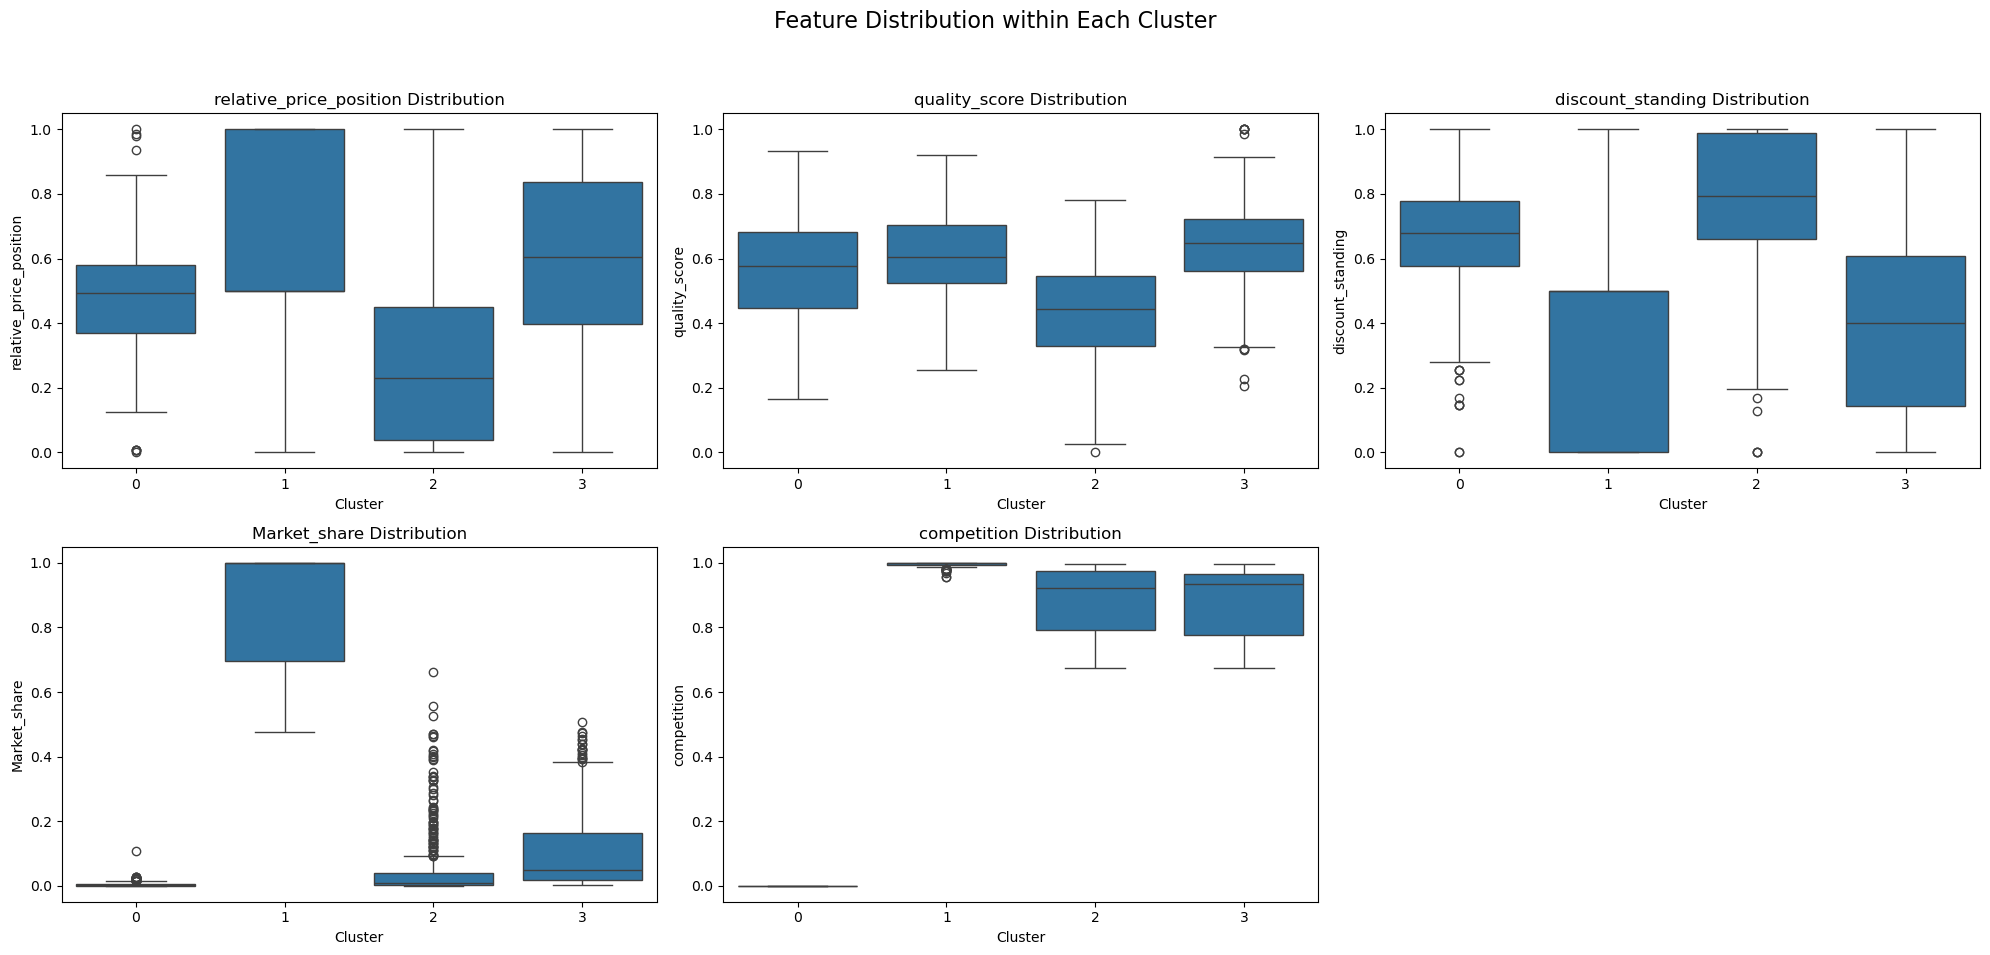

In [60]:
# Box Plots for Feature Distribution
def create_box_plots(df_clustered, features):
    n_features = len(features)
    # Calculate rows needed (assuming 3 columns per row)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    fig.suptitle('Feature Distribution within Each Cluster', fontsize=16)
    axes = axes.flatten()

    for i, feature in enumerate(features):
        sns.boxplot(x='kmean_cluster', y=feature, data=df_clustered, ax=axes[i])
        axes[i].set_title(f'{feature} Distribution')
        axes[i].set_xlabel('Cluster')
        axes[i].set_ylabel(feature)
    
    # Hide empty subplots if any
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Generate the box plots
create_box_plots(df_clustered, investment_features)

#### Box Potls Analysis

**1. Executive Summary of Cluster Profiles**

* **Cluster 0: The Isolated Niche**
    * **Status:** A highly specific niche group with **zero competition** (0.00) and negligible market share (~0.004).
    * **Behavior:** Operates in a vacuum. Despite maintaining a relatively high discount standing (0.66), sales volume remains minimal.
    * **Verdict:** Strategic isolation; lacks scalability.

* **Cluster 1: The Market Leaders**
    * **Status:** The dominant group commanding the highest **Market Share (0.86)** and facing peak **Competition (0.99)**.
    * **Behavior:** Defines the premium segment with high pricing (0.63) and quality (0.61). It succeeds without relying on deep discounts (0.40).
    * **Verdict:** "Cash Cow" / Market Leader.

* **Cluster 2: The Budget Segment**
    * **Status:** The bottom-tier segment defined by the lowest **Price (0.27)** and **Quality (0.43)**.
    * **Behavior:** Engages in a "race to the bottom" with the highest discount rates (0.78) but fails to capture significant market share (0.05).
    * **Verdict:** Inefficient "Dog" category; high effort (promo) for low return.

* **Cluster 3: The High-Potential Challengers**
    * **Status:** The strongest challenger to Cluster 1, boasting the **highest Quality Score (0.64)**.
    * **Behavior:** Adopts premium pricing (0.59) similar to leaders but with the lowest discount rates (0.39). Market share (0.10) does not yet reflect its product superiority.
    * **Verdict:** "Star" potential; high intrinsic value but under-marketed.

**2. Visual Data Analysis**

* **Heatmap Analysis (Metric Intensity)**
    * **Dominance:** Cluster 1 is the only group showing high intensity (bright colors) across both *Competition* and *Market_share*, visualizing its "Winner-takes-all" status.
    * **Contrast:** Cluster 2 shows a sharp contrast—lowest intensity in *Price/Quality* but highest intensity in *Discount/Competition*.
    * **Potential:** Cluster 3 mirrors Cluster 1’s color profile in *Price* and *Quality* but remains dark (low value) in *Market_share*, highlighting the gap between product value and market performance.

* **Radar Chart Analysis (Shape Profiling)**
    * **Cluster 0 (Skewed Triangle):** Retracted entirely to the left (product attributes), missing the right side (market metrics), confirming disconnection from the market.
    * **Cluster 1 (Expansive Polygon):** Covers the largest surface area, indicating a robust balance between intrinsic strength and external market dominance.
    * **Cluster 2 (Arrowhead):** Distorted shape pointing sharply towards *Discount* and *Competition*, reflecting a critical imbalance and reliance on price cuts.
    * **Cluster 3 (Kite):** Peaks at *Quality* and extends to *Price*, but collapses inward at *Market_share*, illustrating a strong product that lacks penetration.

* **Box Plot Analysis (Feature Distributions)**
    * **Price Consistency:** Cluster 2’s price distribution is tightly compressed at the bottom (strict low-price policy), while Cluster 1 shows a wide interquartile range, indicating strategic flexibility between upper-mid and luxury tiers.
    * **Market Dynamics:** Cluster 1 is the only group where the entire distribution box is elevated above zero. For Clusters 2 & 3, the median share is near zero, but **outliers** exist, suggesting success in these groups is limited to specific "lone star" products rather than the whole cluster.
    * **Promotional Structure:** Cluster 2’s discount box is elevated and compact, proving that deep discounting is a structural requirement for survival, not a tactical option.

**3. Strategic Recommendations**

1.  **Cluster 0 (Evaluate):** Conduct a lifecycle review. If these are not new launches, consider discontinuation to reallocate resources, as the niche is too small to sustain growth.
2.  **Cluster 1 (Defend):** Maintain the current course. Focus on customer retention and service quality. Avoid unnecessary price wars or increased discounting, as the position is secure.
3.  **Cluster 2 (Restructure):** Aggressive pruning is required. The strategy of "low quality + high discount" is yielding poor returns. Eliminate underperforming SKUs to protect margins.
4.  **Cluster 3 (Attack):** Shift from a passive to an offensive strategy. The product quality (0.64) is superior to the market leaders. Increase Marketing and Promotion budgets to convert this quality advantage into market share.
-----

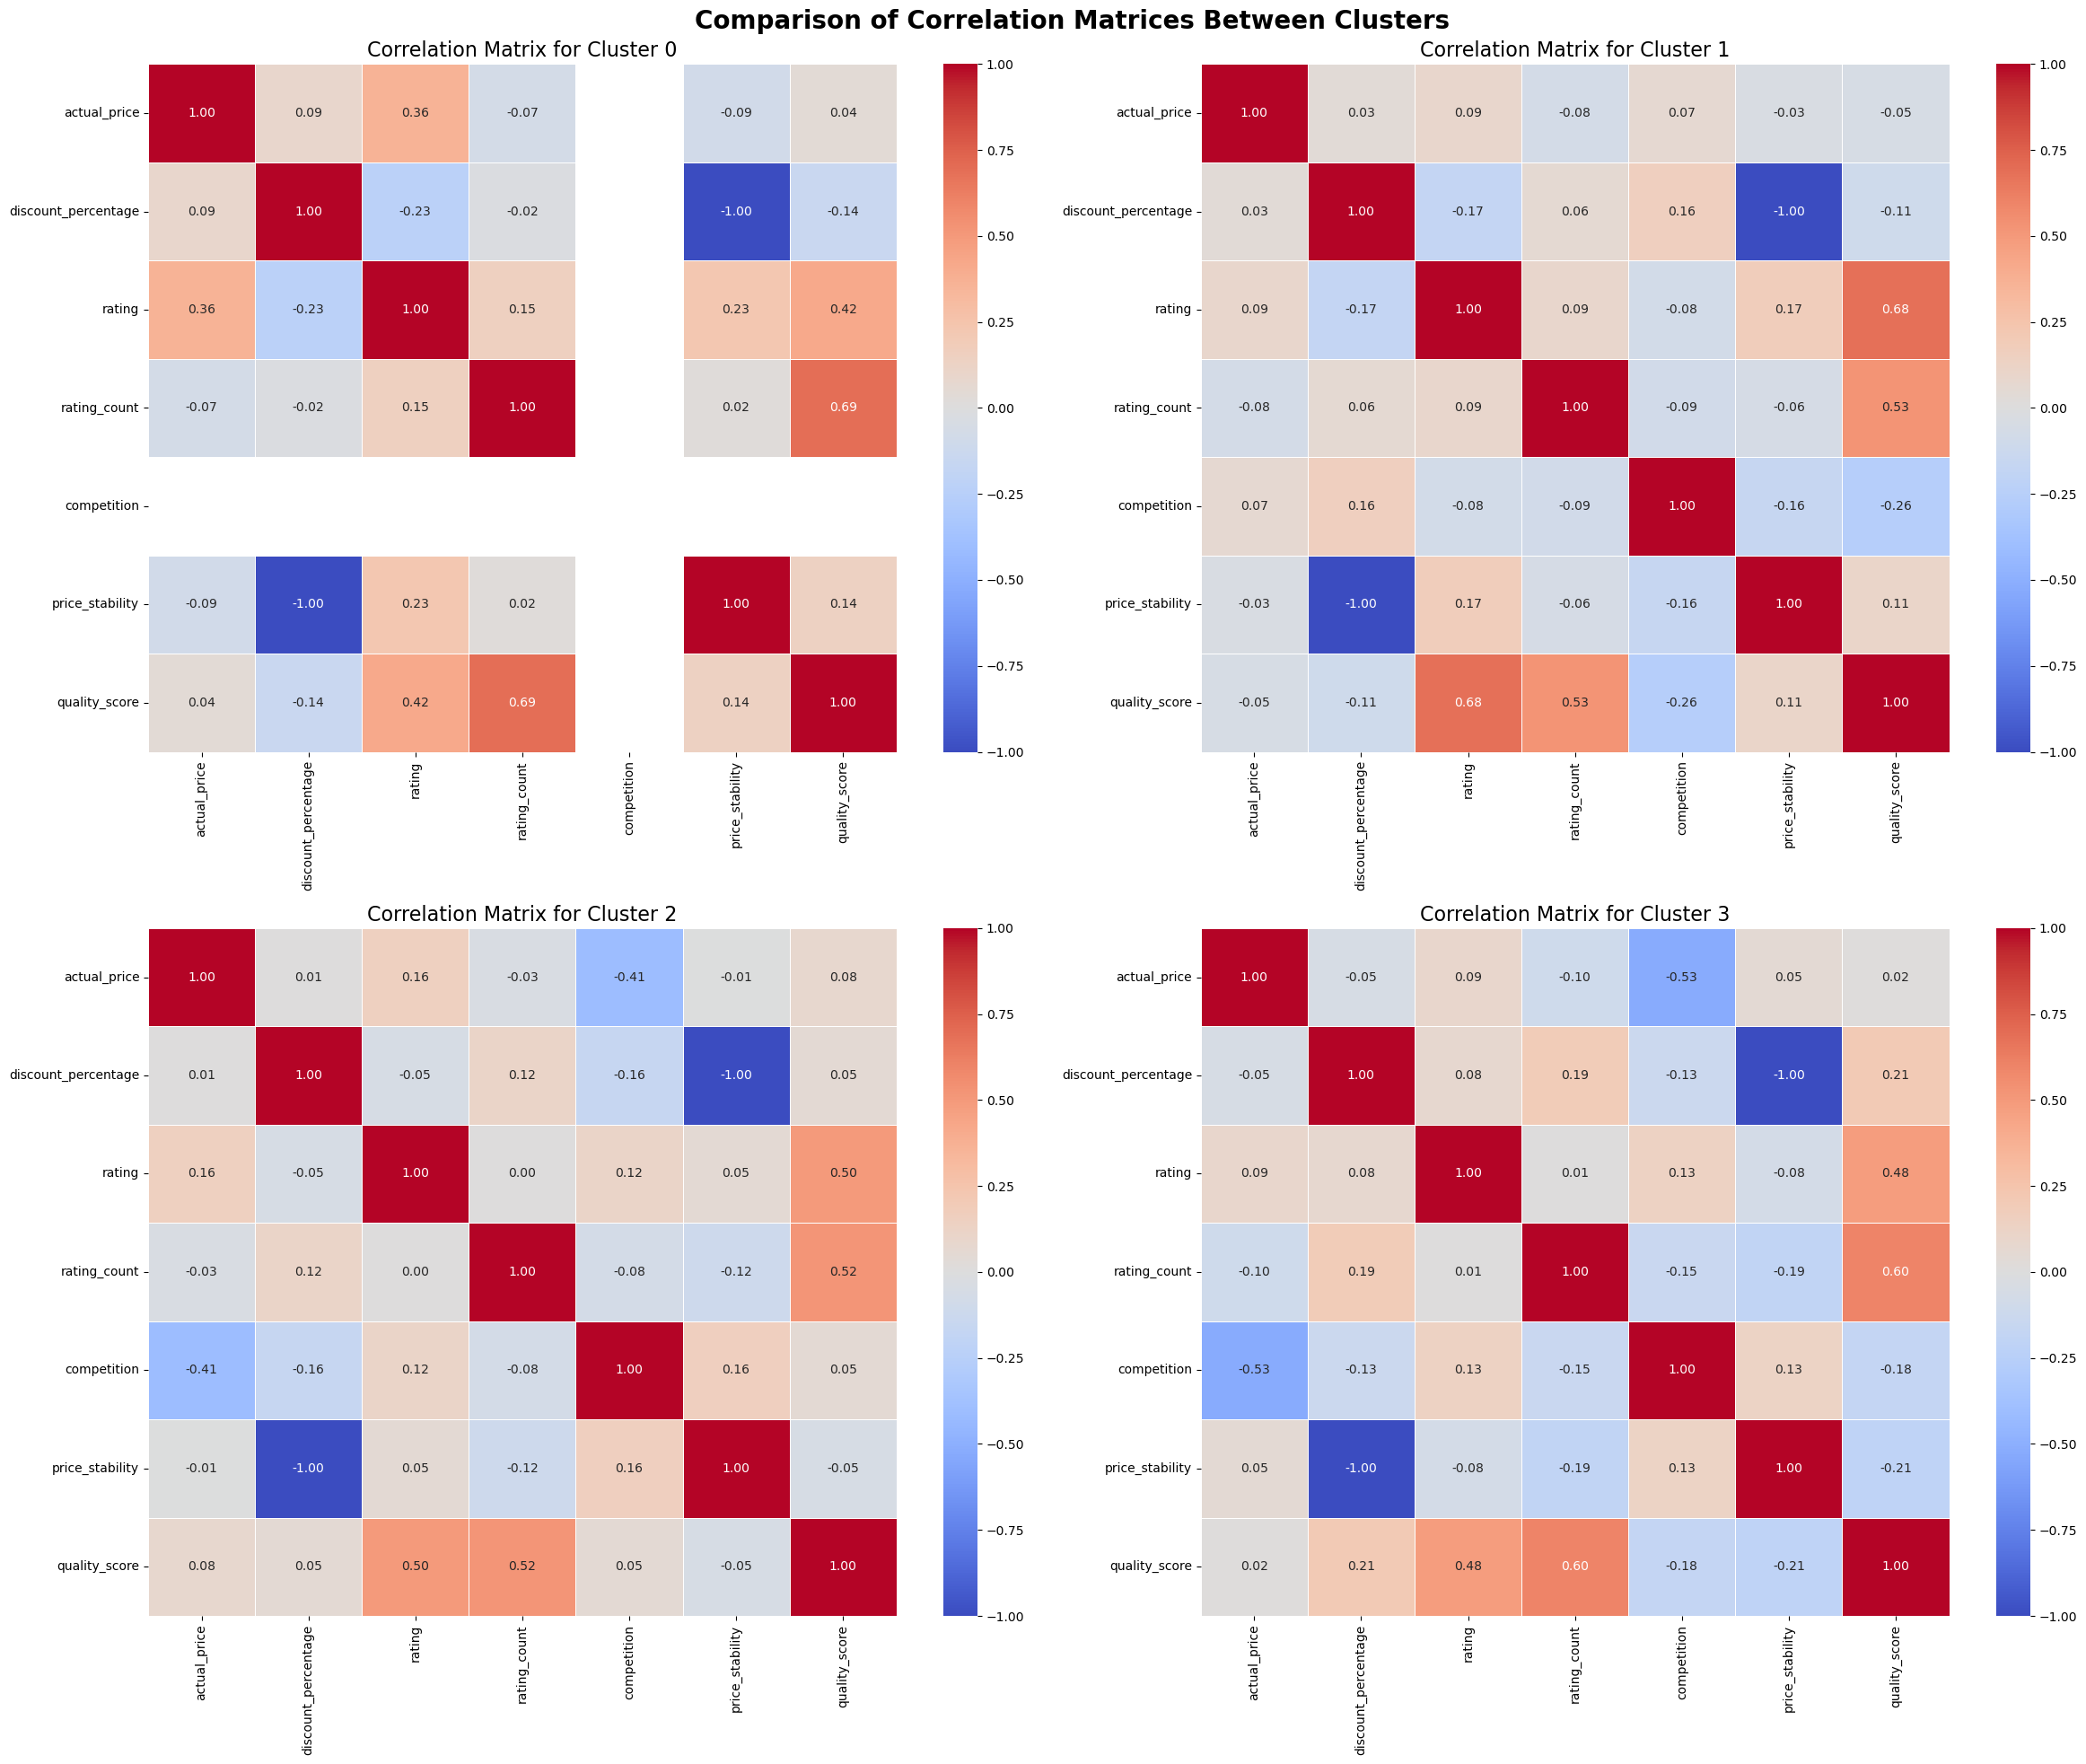

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import math

# Define the features to be included in the correlation analysis
correlation_features = [
    'actual_price', 
    'discount_percentage', 
    'rating', 
    'rating_count',
    'competition', 
    'price_stability', 
    'quality_score'
]

# Get the unique cluster IDs
unique_clusters = sorted(df_clustered['kmean_cluster'].unique())
n_clusters = len(unique_clusters)

# --- Visualization Setup ---
# Dynamically determine subplot grid size
n_cols = 2
n_rows = math.ceil(n_clusters / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12 * n_cols, 10 * n_rows))
axes = axes.flatten() # Flatten the axes array for easy iteration

# Loop through each cluster to create a heatmap on a subplot
for i, cluster_id in enumerate(unique_clusters):
    
    ax = axes[i]
    
    # Filter the dataframe for the current cluster
    cluster_df = df_clustered[df_clustered['kmean_cluster'] == cluster_id]
    
    # Check if the cluster has enough data
    if len(cluster_df) < 2:
        ax.text(0.5, 0.5, "Not enough data\nfor analysis.", ha='center', va='center', fontsize=12)
        ax.set_title(f'Correlation Matrix for Cluster {cluster_id}', fontsize=16)
        ax.set_axis_off()
        continue

    # Calculate the correlation matrix
    corr_matrix = cluster_df[correlation_features].corr()

    # --- Visualization on subplot ---
    sns.heatmap(
        corr_matrix, 
        annot=True, 
        fmt=".2f", 
        cmap='coolwarm',
        linewidths=.5,
        ax=ax
    )
    
    # Add title to the subplot
    ax.set_title(f'Correlation Matrix for Cluster {cluster_id}', fontsize=16)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_axis_off()

# Adjust layout and show the single plot
plt.tight_layout(rect=[0, 0, 1, 0.97]) # Add a bit of space for the suptitle
fig.suptitle('Comparison of Correlation Matrices Between Clusters', fontsize=20, fontweight='bold')
plt.show()

#### Correlation Matrix Analysis (Internal Drivers)

**1. Pricing Power Dynamics**
* **Cluster 1 (Independent):** Shows negligible correlation between `actual_price` and `competition` (0.07), confirming these leaders dictate pricing regardless of market pressure.
* **Cluster 3 (Reactive):** Displays a strong negative correlation (-0.53), indicating they are "price takers" forced to lower prices as competition intensifies.

**2. Quality Conversion ROI**
* **Cluster 1 (Satisfaction):** Achieves the highest conversion of `quality_score` into `rating` (0.68), meaning quality investments directly yield customer satisfaction.
* **Cluster 3 (Visibility):** Quality correlates strongly with `rating_count` (0.60), suggesting that for challengers, superior product quality is the primary driver of traffic and market attention.

**3. Stability vs. Discounting**
* **Universal Trade-off:** A perfect negative correlation (-1.00) between `price_stability` and `discount_percentage` exists across all clusters. This mathematically confirms that the heavy discounting strategy of **Cluster 2** guarantees price instability, eroding long-term brand equity.

**4. Statistical Isolation**
* **Cluster 0:** The `competition` variable is null/empty, providing definitive statistical proof that this group operates in complete isolation from market forces.

---------------------------------------------

### Step 8: Evaluating the Kmean model

**1. Market Truths & Core Insights**
* **Quality is King:** The market is unequivocally driven by quality rather than low pricing. **Cluster 1** (High Price/High Quality) commands the vast majority of market share (86%), whereas **Cluster 2** (Low Price/Low Quality) fails completely despite maximum discounting.
* **The Discount Trap:** Aggressive discounting is proven to be counterproductive. The perfect negative correlation (-1.00) between `price_stability` and `discount_percentage` indicates that the heavy promotional strategy of Cluster 2 erodes price stability without gaining market traction.
* **Winner-Takes-All Dynamic:** The market is not evenly distributed. The **Leader** group absorbs nearly all volume, forcing other clusters into negligible niches or direct attrition.

**2. Strategic Cluster Re-positioning**

* **Cluster 1 (The Fortress):**
    * *Role:* **Defensive Anchor.**
    * *Analysis:* This group is in an ideal state. As "Price Makers," they dictate terms independent of competitive pressure and efficiently convert high quality into customer satisfaction.
* **Cluster 3 (The Sleeping Giant):**
    * *Role:* **Offensive Asset.**
    * *Analysis:* The most critical finding. This group possesses superior product quality (0.64)—surpassing even the Leaders—but remains under-commercialized. It is a "Price Taker" sensitive to competition, currently held back by a lack of visibility rather than product deficiency.
* **Cluster 2 (The Money Pit):**
    * *Role:* **Liability.**
    * *Analysis:* Structurally unsound. This segment suffers from high variance in quality and a dependency on deep discounts to survive. It consumes resources (margin erosion) with minimal return on investment.
* **Cluster 0 (The Ghost):**
    * *Role:* **Irrelevant.**
    * *Analysis:* Statistically isolated with zero competition data. It represents a non-viable or dead inventory category.

----

## DBSCAN CLUSTERING (Refactored & Automated)

### Step 1: Data normalization

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from kneed import KneeLocator
from IPython.display import display, Markdown

# Use data from K-Means section
X_scaled = scaled_data 

print(f"Data shape for DBSCAN: {X_scaled.shape}")

Data shape for DBSCAN: (1462, 5)


### Step 2: Simulate `min_samples` and `sensitivity`.

In [63]:
# Configuration
min_samples_range = range(6, 30)
sensitivity_range = np.arange(1, 15, 1)
results_list = []
case_counter = 1

print(f"Calculating {len(min_samples_range) * len(sensitivity_range)} cases. Please wait...")

# Grid Search
for ms in min_samples_range:
    # Calculate K-distance once per min_samples (Parallelized)
    neighbors = NearestNeighbors(n_neighbors=ms + 1, n_jobs=-1).fit(X_scaled)
    distances, _ = neighbors.kneighbors(X_scaled)
    sorted_distances = np.sort(distances[:, -1])
    
    # Setup data for knee detection
    y_truncated = sorted_distances
    x_truncated = np.arange(len(y_truncated))
    
    for s_val in sensitivity_range:
        # Detect Elbow
        kneedle = KneeLocator(x=x_truncated, y=y_truncated, curve='convex', direction='increasing', S=s_val)
        found_eps = kneedle.elbow_y
        
        if found_eps is None: 
            continue
        
        # Add small epsilon
        adjusted_eps = found_eps + 1e-6
        
        # Run DBSCAN (Parallelized)
        db = DBSCAN(eps=adjusted_eps, min_samples=ms, n_jobs=-1).fit(X_scaled)
        labels = db.labels_
        
        # Metrics
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_pct = (n_noise / len(labels)) * 100
        
        sil_score = 0
        if n_clusters > 1:
            sil_score = silhouette_score(X_scaled, labels)
            
        results_list.append({
            'Case': case_counter,
            'Min Samples': ms,
            'Sensitivity': s_val,
            'Eps Found': round(adjusted_eps, 4),
            'Clusters': n_clusters,
            'Noise %': round(noise_pct, 2),
            'Silhouette Score': round(sil_score, 4)
        })
        
        case_counter += 1

# Process Results
df_results = pd.DataFrame(results_list)
df_valid = df_results[df_results['Clusters'] > 1].copy()

print(f"Calculation complete. Found {len(df_valid)} valid cases with > 1 cluster.")

if not df_valid.empty:
    # Sort by Silhouette Score
    df_valid = df_valid.sort_values(by='Silhouette Score', ascending=False)

    # Interactive 3D Visualization
    print("Generating 3D Plot...")
    
    fig = px.scatter_3d(
        df_valid, 
        x='Min Samples', 
        y='Sensitivity', 
        z='Noise %',
        color='Silhouette Score',
        color_continuous_scale='Viridis',
        size_max=15,
        opacity=0.8,
        hover_data={
            'Case': True,
            'Min Samples': True,
            'Sensitivity': True,
            'Noise %': ':.2f',
            'Eps Found': ':.4f',      
            'Clusters': True,
            'Silhouette Score': ':.4f'
        },
        title="DBSCAN Optimization: Min_Samples vs Sensitivity vs Noise"
    )

    fig.update_layout(
        scene = dict(
            xaxis_title='Min Samples',
            yaxis_title='Sensitivity',
            zaxis_title='Noise Percentage (%)',
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()

Calculating 336 cases. Please wait...
Calculation complete. Found 336 valid cases with > 1 cluster.
Generating 3D Plot...


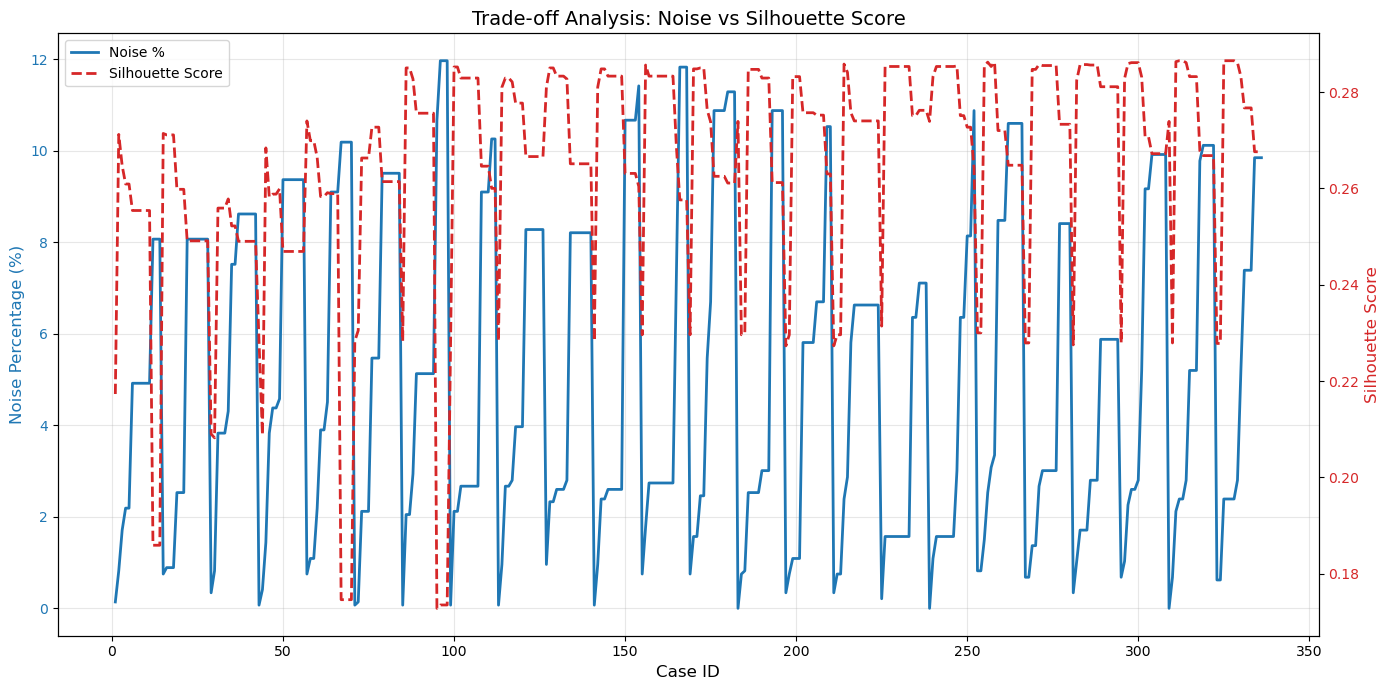

In [64]:
# Ensure df_results exists from the previous step
# Use df_valid instead of df_results to plot only valid cases (>1 cluster)
df_plot = df_results.copy() 

fig, ax1 = plt.subplots(figsize=(14, 7))

# Left Y-axis: Noise % (Blue)
color = 'tab:blue'
ax1.set_xlabel('Case ID', fontsize=12)
ax1.set_ylabel('Noise Percentage (%)', color=color, fontsize=12)
ax1.plot(df_plot['Case'], df_plot['Noise %'], color=color, linewidth=2, label='Noise %')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Right Y-axis: Silhouette Score (Red)
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color, fontsize=12)
ax2.plot(df_plot['Case'], df_plot['Silhouette Score'], color=color, linewidth=2, linestyle='--', label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color)

# Title and Adjustments
plt.title('Trade-off Analysis: Noise vs Silhouette Score', fontsize=14)
fig.tight_layout()  

# Combined Legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()

### Step 3: Find suitable `cases`

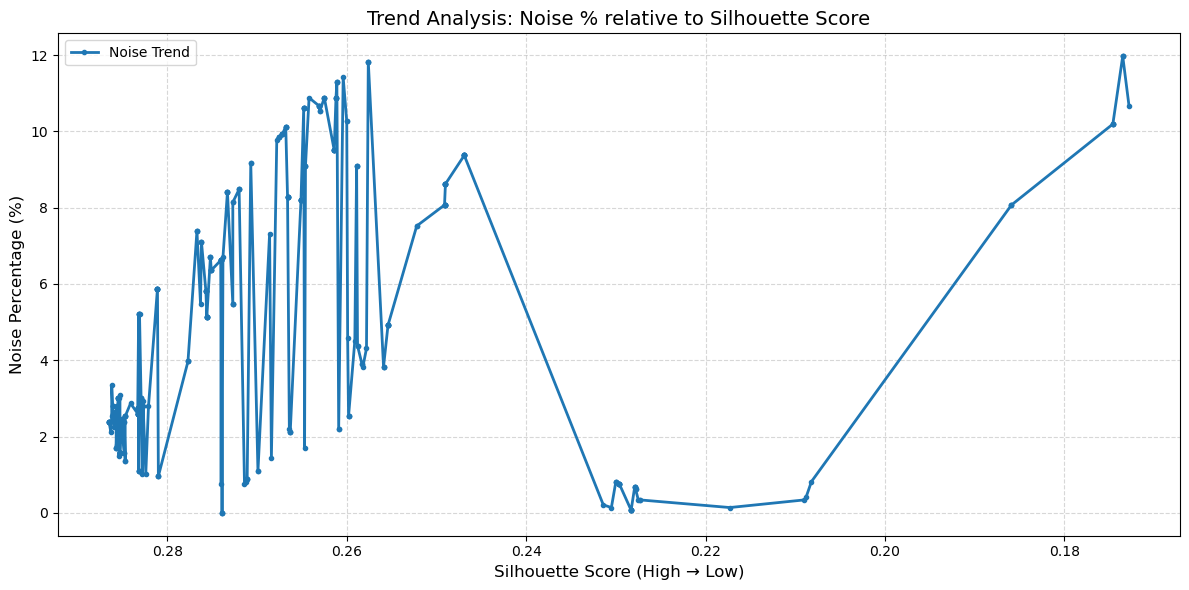

In [65]:
# Prepare Data
# Filter valid clusters and sort by Silhouette Score (descending)
df_line = df_results[df_results['Clusters'] > 1].sort_values(by='Silhouette Score', ascending=False)

# Setup Plot
plt.figure(figsize=(12, 6))

# Draw Line Plot
plt.plot(
    df_line['Silhouette Score'], 
    df_line['Noise %'], 
    marker='o',          
    markersize=3,
    linestyle='-',       
    linewidth=2,
    color='tab:blue',
    label='Noise Trend'
)

# Invert X-Axis
plt.gca().invert_xaxis()

# Formatting
plt.title('Trend Analysis: Noise % relative to Silhouette Score', fontsize=14)
plt.xlabel('Silhouette Score (High → Low)', fontsize=12)
plt.ylabel('Noise Percentage (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

### Step 4: Train Model and Visualization by case

Starting Deep Dive Analysis for Cases: [312, 319, 167]...
ANALYZING CASE 312


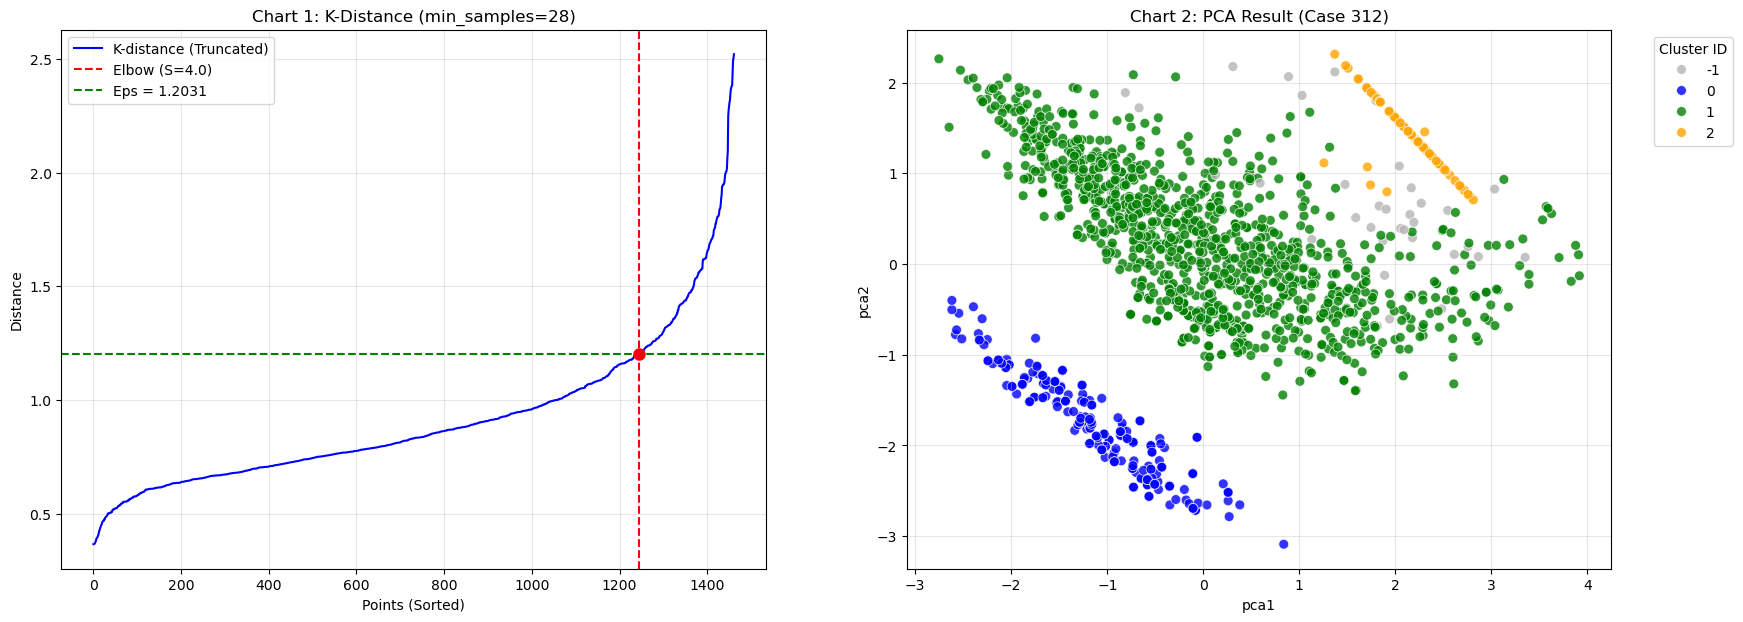

Case 312: Clusters=3  | Noise= 2.39% (35  ) | Silhouette=0.2865 | Params(Eps=1.2031, MS=28, S=4.0)
ANALYZING CASE 319


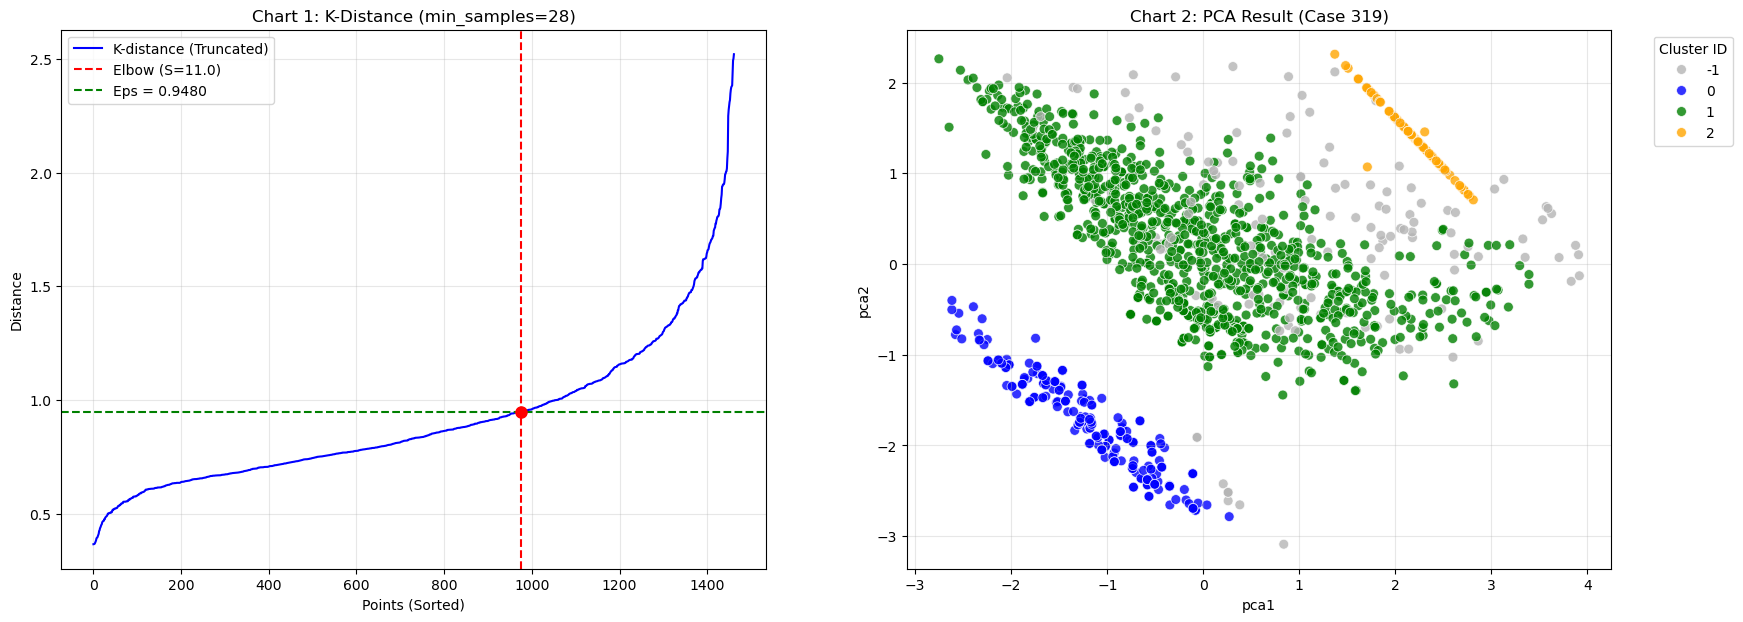

Case 319: Clusters=3  | Noise=10.12% (148 ) | Silhouette=0.2668 | Params(Eps=0.9480, MS=28, S=11.0)
ANALYZING CASE 167


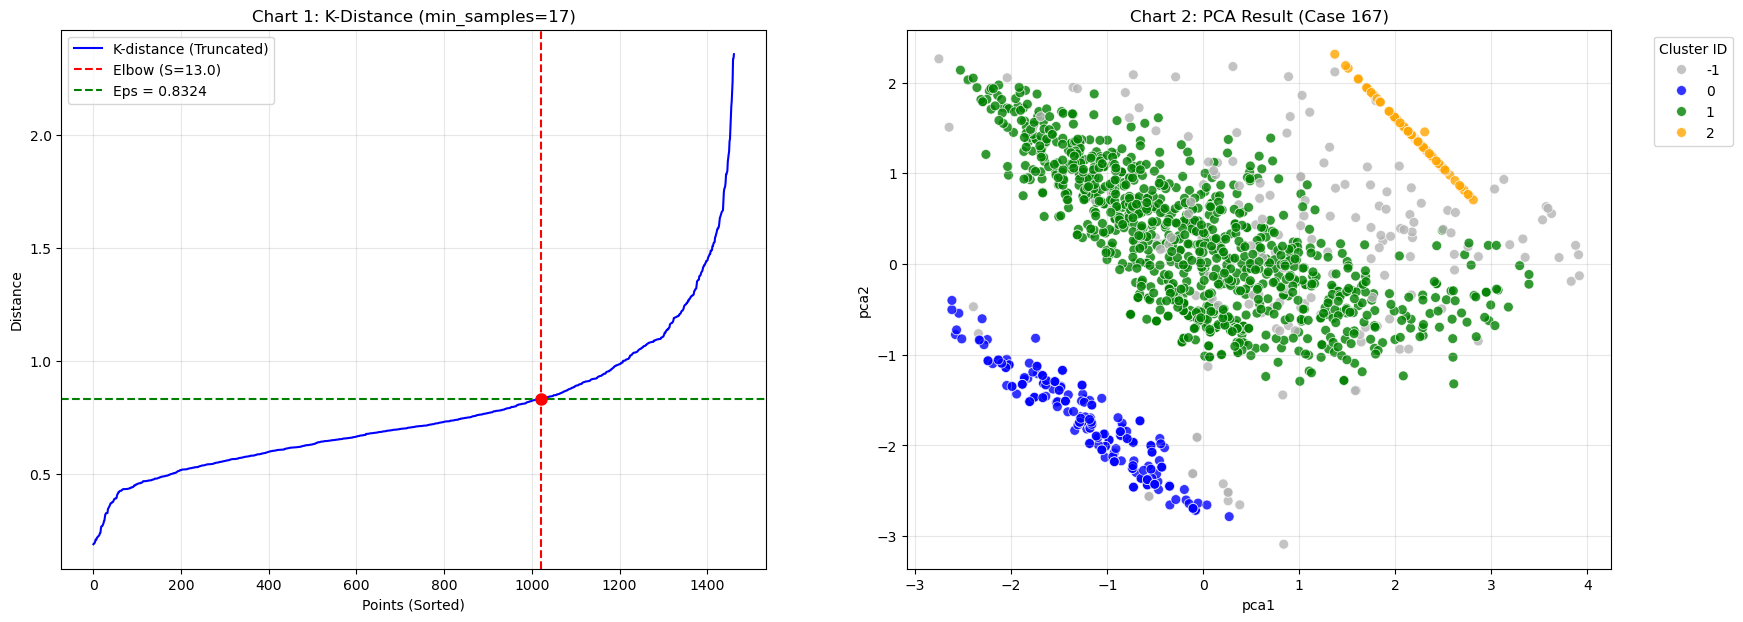

Case 167: Clusters=3  | Noise=11.83% (173 ) | Silhouette=0.2576 | Params(Eps=0.8324, MS=17, S=13.0)


In [66]:
# INPUT: SELECT CASES TO COMPARE
target_case_ids = [312, 319, 167] 

print(f"Starting Deep Dive Analysis for Cases: {target_case_ids}...")

# Dictionary to store labels for comparison
comparison_dict = {}

# Ensure PCA exists for visualization
if 'pca1' not in df.columns:
    print("Calculating PCA for visualization...")
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    df['pca1'], df['pca2'] = X_pca[:, 0], X_pca[:, 1]

# LOOP THROUGH EACH CASE: CALCULATE & VISUALIZE
for case_id in target_case_ids:
    print("="*80)
    print(f"ANALYZING CASE {case_id}")
    
    # Retrieve Parameters
    try:
        row = df_results[df_results['Case'] == case_id].iloc[0]
        ms_val = int(row['Min Samples'])
        eps_val = row['Eps Found']
        sens_val = row['Sensitivity'] 
        score_val = row['Silhouette Score']
        noise_val = row['Noise %']
        n_clusters_val = int(row['Clusters'])
    except IndexError:
        print(f"Error: Case {case_id} not found in df_results. Skipping.")
        continue

    # Re-Calculate K-Distance (Parallelized)
    neighbors = NearestNeighbors(n_neighbors=ms_val + 1, n_jobs=-1).fit(X_scaled)
    distances, _ = neighbors.kneighbors(X_scaled)
    sorted_distances = np.sort(distances[:, -1])
    
    y_truncated = sorted_distances
    x_truncated = np.arange(len(y_truncated))
    
    # Detect Knee again
    kneedle = KneeLocator(x=x_truncated, y=y_truncated, curve='convex', direction='increasing', S=sens_val)
    
    # Run DBSCAN (Parallelized)
    db = DBSCAN(eps=eps_val, min_samples=ms_val, n_jobs=-1).fit(X_scaled)
    labels = db.labels_
    
    # Calculate exact noise count
    n_noise_count = list(labels).count(-1)
    
    # Store for comparison table
    comparison_dict[f'Case_{case_id}'] = [f"Cluster {x}" if x != -1 else "NOISE" for x in labels]

    # VISUALIZATION
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    
    # CHART 1: K-Distance Plot
    axes[0].plot(x_truncated, y_truncated, color='blue', label='K-distance (Truncated)')
    axes[0].axvline(x=kneedle.knee, color='red', linestyle='--', label=f'Elbow (S={sens_val})')
    axes[0].axhline(y=eps_val, color='green', linestyle='--', label=f'Eps = {eps_val:.4f}')
    if kneedle.knee is not None:
        axes[0].plot(kneedle.knee, kneedle.elbow_y, 'ro', markersize=8)
    axes[0].set_title(f'Chart 1: K-Distance (min_samples={ms_val})', fontsize=12)
    axes[0].set_xlabel('Points (Sorted)')
    axes[0].set_ylabel('Distance')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # CHART 2: PCA Cluster Result
    df_plot = df.copy()
    df_plot['temp_cluster'] = labels
    
    # Custom color logic
    unique_labels = sorted(list(set(labels)))
    custom_palette = {}
    
    extra_colors = ['green', 'orange', 'purple', 'brown', 'pink', 'cyan', 'olive']
    
    for lbl in unique_labels:
        if lbl == -1:
            custom_palette[lbl] = '#B5B5B5'       # Noise is Pink
        elif lbl == 0:
            custom_palette[lbl] = 'blue'      # Cluster 0 is Blue
        else:
            color_idx = (lbl - 1) % len(extra_colors)
            custom_palette[lbl] = extra_colors[color_idx]

    sns.scatterplot(
        data=df_plot, x='pca1', y='pca2', hue='temp_cluster', 
        palette=custom_palette, 
        s=50, alpha=0.8, ax=axes[1], legend='full'
    )
    axes[1].set_title(f'Chart 2: PCA Result (Case {case_id})', fontsize=12)
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Cluster ID")
    axes[1].grid(True, alpha=0.3)
    
    plt.show()

    # PRINT MODEL INFORMATION
    summary_line = (
        f"Case {case_id:<3}: "
        f"Clusters={n_clusters_val:<2} | "
        f"Noise={noise_val:5.2f}% ({n_noise_count:<4}) | "
        f"Silhouette={score_val:.4f} | "
        f"Params(Eps={eps_val:.4f}, MS={ms_val:<2}, S={sens_val:<2})"
    )
    print(summary_line)

# Create Comparison DataFrame
df_compare = pd.DataFrame(comparison_dict, index=df.index)
def is_controversial(row):
    values = row.values
    has_noise = any("NOISE" in v for v in values)
    has_cluster = any("Cluster" in v for v in values)
    return has_noise and has_cluster
df_controversial = df_compare[df_compare.apply(is_controversial, axis=1)].copy()

In [67]:
info_columns = ['product_id', 'competition', 'price_stability', 'quality_score']
df_info = df[info_columns]
df_Noise_filtering = df_info.join(df_controversial, how='inner')
print("FINAL MERGED DATAFRAME (Info First -> Analysis Second):")
print(f"Total Rows: {len(df_Noise_filtering)}")
print("-" * 80)

display(df_Noise_filtering)

FINAL MERGED DATAFRAME (Info First -> Analysis Second):
Total Rows: 145
--------------------------------------------------------------------------------


product_id  competition  price_stability  quality_score   Case_312  \
7     B08DDRGWTJ     0.000000             0.77       0.756172  Cluster 0   
12    B07KSMBL2H     0.900000             0.31       1.000000  Cluster 1   
15    B083342NKJ     0.000000             0.87       0.754653  Cluster 0   
33    B008FWZGSG     0.000000             1.00       0.422684  Cluster 0   
40    B00NH11KIK     0.000000             0.30       0.933675  Cluster 0   
...          ...          ...              ...            ...        ...   
1420  B01F7B2JCI     0.991304             0.41       0.591042  Cluster 1   
1434  B015GX9Y0W     0.991304             0.50       0.419645  Cluster 1   
1445  B0B97D658R     0.991304             0.62       0.263943  Cluster 1   
1459  B0B3JSWG81     0.908696             0.20       0.024993  Cluster 1   
1462  B009P2LIL4     0.995652             0.72       0.305426  Cluster 1   

       Case_319 Case_167  
7     Cluster 0    NOISE  
12        NOISE    NOISE  
15        NOISE    NOISE  
33        NOISE    NOISE  
40    Cluster 0    NOISE  
...         ...      ...  
1420      NOISE    NOISE  
1434      NOISE    NOISE  
1445      NOISE    NOISE  
1459  Cluster 1    NOISE  
1462      NOISE    NOISE  

[145 rows x 7 columns]

### Step 5: Select the final model and visualize.

In [68]:
# --- CONFIG ---
CASE_ID = 319 

try:
    # 1. Prepare Data & Model
    params = df_results.loc[df_results['Case'] == CASE_ID].iloc[0]
    
    # 2. Train and assign to the final column name
    print(f"Training final DBSCAN model based on Case {CASE_ID} and assigning to 'dbscan_cluster'...")
    dbscan = DBSCAN(eps=params['Eps Found'], min_samples=int(params['Min Samples']), n_jobs=-1)
    df = df.assign(dbscan_cluster = dbscan.fit_predict(X_scaled))

    # 3. Visualize
    df.loc[:, 'label'] = df['dbscan_cluster'].astype(str)
    fig = px.scatter(
        df, x='pca1', y='pca2', color='label',
        title=f'Final Cluster Result: Case {CASE_ID}',
        color_discrete_map={'-1': 'lightgrey'},
        category_orders={"label": sorted(df['label'].unique(), key=lambda x: int(x))}
    )
    fig.show()
    # Clean up the temporary 'label' column
    df = df.drop(columns=['label'])

    print("Visualization complete.")

except Exception as e:
    print(f"Error: {e}")

Training final DBSCAN model based on Case 319 and assigning to 'dbscan_cluster'...


Visualization complete.


### Step 6: Cluster Analysis.

--- Advanced Profiling for dbscan_cluster (Including Noise) ---



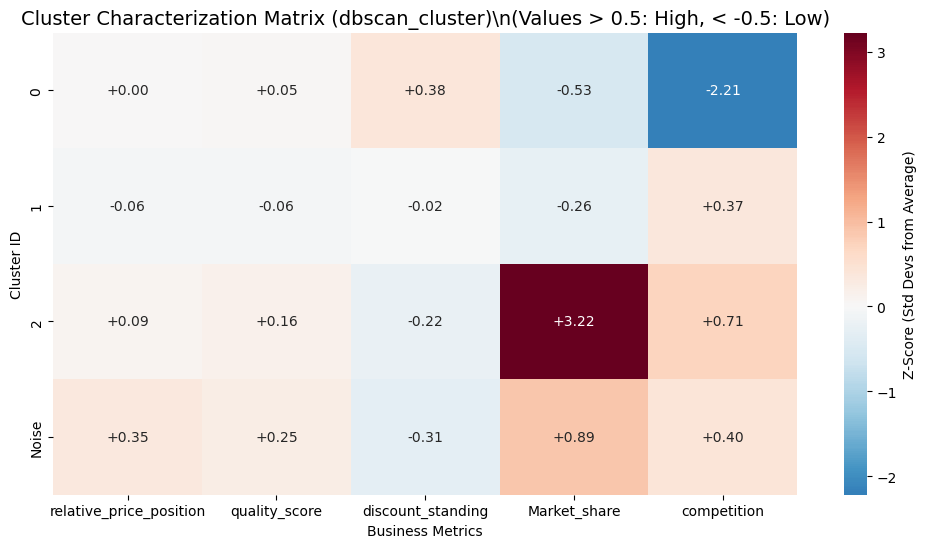

#### Automated Interpretation:

- **0**: Low Market_share (-0.5σ), Low competition (-2.2σ)
- **1**: Average Market Performer (No extreme traits).
- **2**: High Market_share (+3.2σ), High competition (+0.7σ)
- **Noise**: High Market_share (+0.9σ)


In [69]:
# Automated Cluster Profiling & Interpretation (Optimized with Z-Score)
def profile_clusters_advanced(df, cluster_col, features):
    """
    Analyzes clusters by comparing their means to the global population average using Z-Score.
    Generates a Heatmap of Z-Scores and text descriptions.
    """
    print(f"--- Advanced Profiling for {cluster_col} (Including Noise) ---\n")
    
    # 1. Use the full dataframe
    valid_df = df.copy()
    
    # Rename -1 to 'Noise' for better visualization
    if -1 in valid_df[cluster_col].unique():
        valid_df[cluster_col] = valid_df[cluster_col].astype(str).replace('-1', 'Noise')

    # 2. Calculate Global Statistics
    global_mean = valid_df[features].mean()
    global_std = valid_df[features].std()
    
    # Handle zero std case to avoid division by zero
    global_std = global_std.replace(0, 1)

    # 3. Calculate Cluster Means
    cluster_means = valid_df.groupby(cluster_col)[features].mean()
    
    # 4. Calculate Z-Scores -> (Cluster - Global) / Std
    # This shows how many standard deviations a cluster is from the mean
    z_scores = (cluster_means - global_mean) / global_std
    
    # 5. Visualization: Heatmap
    plt.figure(figsize=(12, len(cluster_means) * 1.0 + 2))
    sns.heatmap(
        z_scores, 
        annot=True, 
        fmt="+.2f", 
        cmap="RdBu_r", 
        center=0, 
        cbar_kws={'label': 'Z-Score (Std Devs from Average)'}
    )
    plt.title(f'Cluster Characterization Matrix ({cluster_col})\\n(Values > 0.5: High, < -0.5: Low)', fontsize=14)
    plt.xlabel('Business Metrics')
    plt.ylabel('Cluster ID')
    plt.show()
    
    # 6. Automated Interpretation
    display(Markdown("#### Automated Interpretation:"))
    for cluster_id in cluster_means.index:
        desc = []
        for feature in features:
            val = z_scores.loc[cluster_id, feature]
            if val > 0.5:
                desc.append(f"High {feature} (+{val:.1f}σ)")
            elif val < -0.5:
                desc.append(f"Low {feature} ({val:.1f}σ)")
        
        # Construct sentence
        if not desc:
            summary = "Average Market Performer (No extreme traits)."
        else:
            summary = ", ".join(desc)
            
        print(f"- **{cluster_id}**: {summary}")

# Run the profiling
profile_features = ['relative_price_position', 'quality_score', 'discount_standing', 'Market_share', 'competition']

if 'dbscan_cluster' in df.columns:
    profile_clusters_advanced(df, 'dbscan_cluster', profile_features)
else:
    print("DBSCAN cluster column not found. Run the training step above first.")

In [70]:
# --- Radar Chart Visualization (Valid Clusters) ---
print("\n--- Radar Chart Visualization (Valid Clusters) ---")

profile_features = ['relative_price_position', 'quality_score', 'discount_standing', 'Market_share', 'competition']

if 'dbscan_cluster' in df.columns:
    valid_dbscan_df = df.copy()

    if not valid_dbscan_df.empty:
        radar_means = valid_dbscan_df.groupby('dbscan_cluster')[profile_features].mean()
        try:
            create_optimized_radar_chart(radar_means, profile_features)
        except NameError:
            print("Error: 'create_optimized_radar_chart' not found. Run K-Means visualization cells first.")
    else:
        print("No valid clusters (excluding noise) found for Radar Chart.")
else:
    print("DBSCAN cluster column not found.")


--- Radar Chart Visualization (Valid Clusters) ---


### 1. Cluster Range Analysis

relative_price_position quality_score discount_standing  \
                                  mean          mean              mean   
dbscan_cluster                                                           
-1                            0.577067      0.595748          0.469883   
 0                            0.471971      0.561758          0.678729   
 1                            0.454110      0.544578          0.557997   
 2                            0.499931      0.580475          0.498090   

               Market_share competition  
                       mean        mean  
dbscan_cluster                           
-1                 0.379975    0.896416  
 0                 0.004267    0.000000  
 1                 0.075922    0.885406  
 2                 0.996823    0.999774

### 2. Cluster Density (Pairplot)

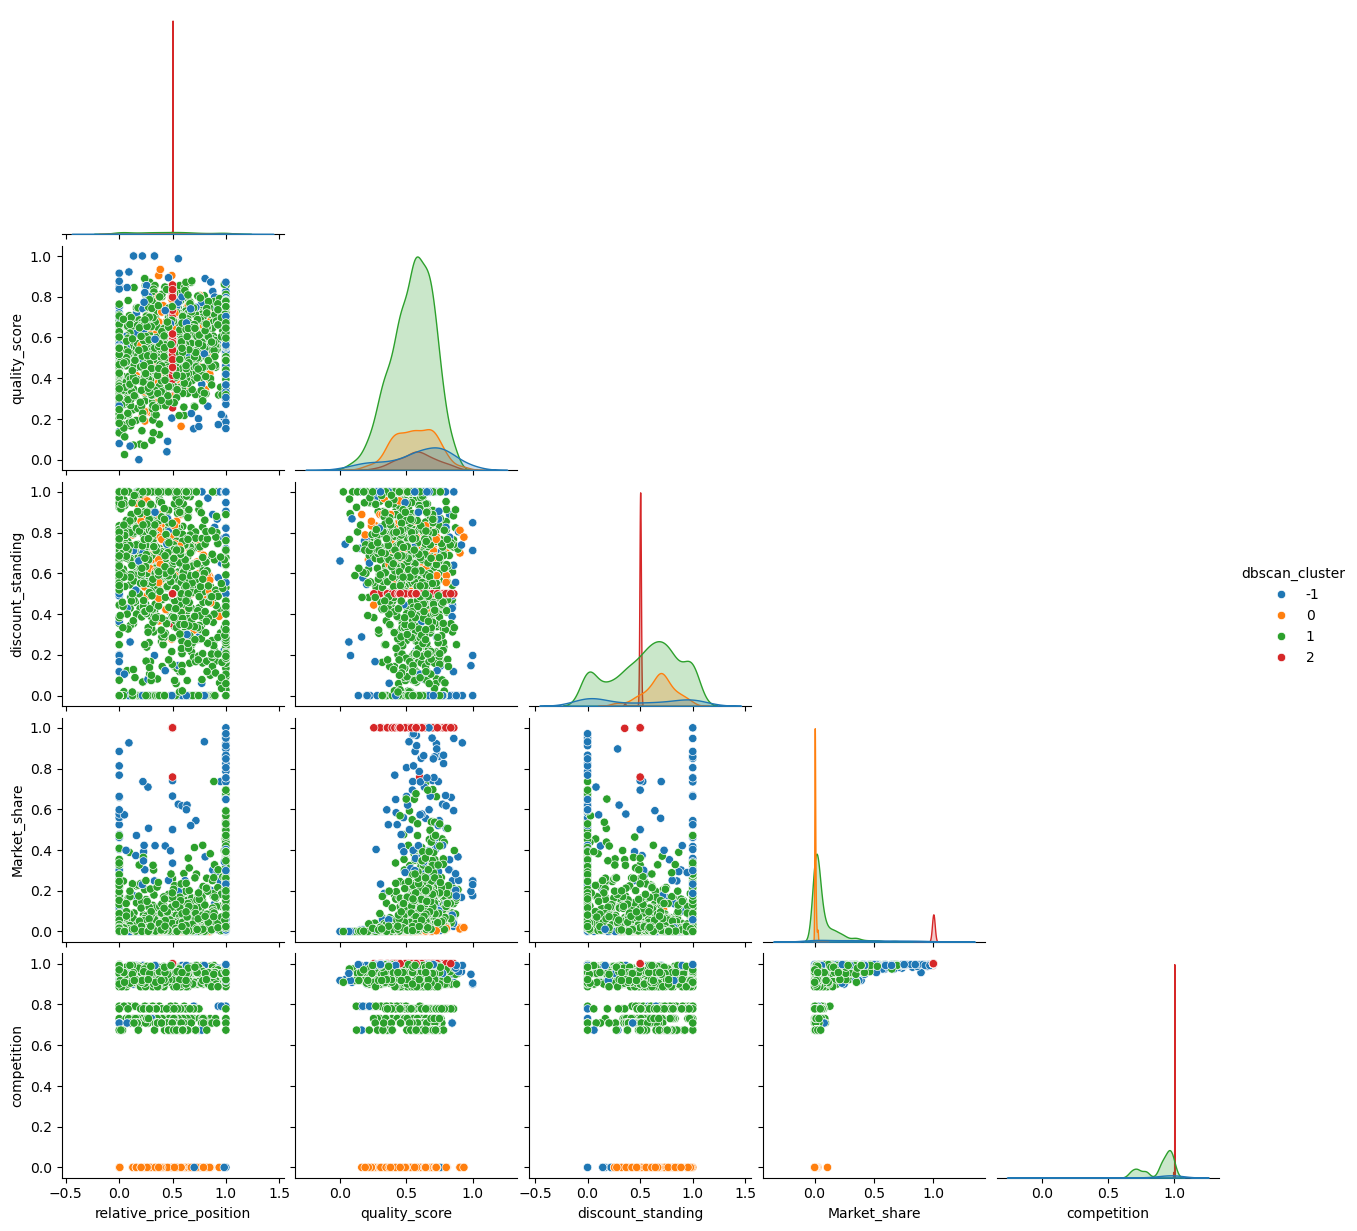

### 3. Internal Correlations

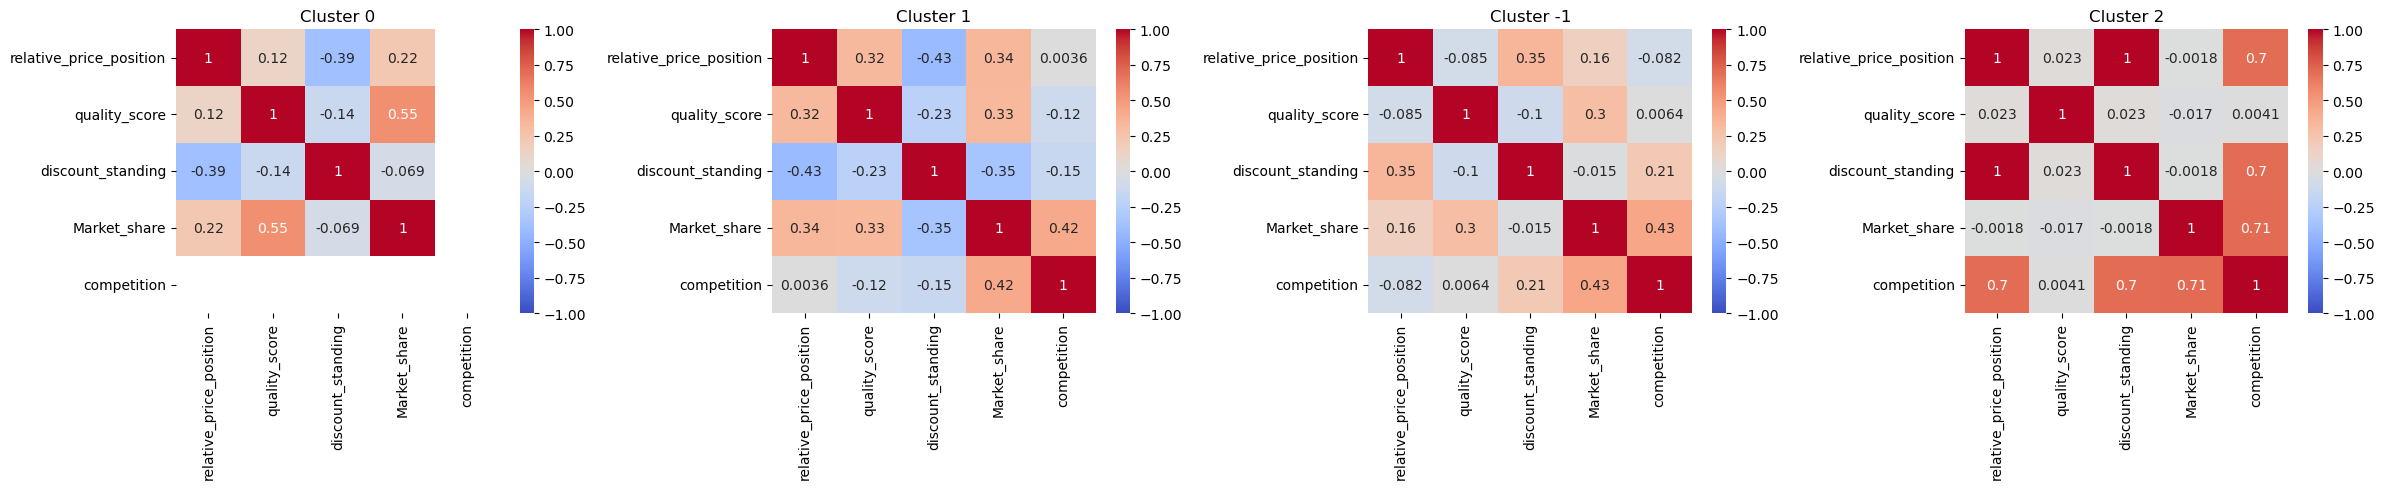

In [71]:
features = ['relative_price_position', 'quality_score', 'discount_standing', 'Market_share', 'competition']

# 1. Cluster Boundaries
display(Markdown("### 1. Cluster Range Analysis"))
display(df.groupby('dbscan_cluster')[features].agg(['mean']))

# 2. Cluster Density Visualization
display(Markdown("### 2. Cluster Density (Pairplot)"))
sns.pairplot(df, vars=features, hue='dbscan_cluster', palette='tab10', corner=True)
plt.show()

# 3. Internal Feature Correlations
display(Markdown("### 3. Internal Correlations"))

# FIX: Get unique cluster IDs instead of copying the whole DataFrame
valid_clusters = df['dbscan_cluster'].unique()

# FIX: Check len() > 0. Direct boolean check on numpy arrays/DataFrames is ambiguous.
if len(valid_clusters) > 0:
    fig, axes = plt.subplots(1, len(valid_clusters), figsize=(6 * len(valid_clusters), 5))
    
    # Handle the case where subplots returns a single Axes object (not a list)
    if len(valid_clusters) == 1: 
        axes = [axes]
        
    for ax, c_id in zip(axes, valid_clusters):
        sns.heatmap(df[df['dbscan_cluster'] == c_id][features].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax)
        ax.set_title(f'Cluster {c_id}')
    plt.tight_layout()
    plt.show()


#### 1. Cluster 2: The Disciplined Elite
This group exhibits the most superior performance and adheres to the strictest operational rules.

* **Geometry & Density Characteristics:**
    * On the PCA chart, this group distributes into a distinct **linear shape (straight line)**, completely isolated in the upper section.
    * On the Pairplot, the data density converges into an extremely small, sharp point at the highest value range. This proves absolute uniformity in the behavior of products within this group.
* **Performance Metrics (Z-Score):**
    * **Market Share:** Reaches +3.22, exceptionally higher than the market average.
    * **Competition:** +0.71, operating in a high-competition environment.
    * **Discount:** -0.22, lower than the average.
* **Internal Structure (Correlation):**
    * The correlation matrix reveals that the coefficient between `relative_price_position` and `discount_standing` is **+1.0 (Absolute)**.
    * **Insight:** This group applies a rigid pricing algorithm: Price and Discount move in perfect proportion to one another. This discipline allows them to dominate market share without being dragged into chaotic price wars.

#### 2. Cluster 1: The Standard Mass
This group represents the majority of the market, containing the densest concentration of products but lacking distinctive features.

* **Geometry & Density Characteristics:**
    * Forms a large data cloud in the center of the PCA chart.
    * Density spreads widely across the Price and Quality axes in the Pairplot, indicating diversity (or looseness) in product standards.
* **Performance Metrics (Z-Score):**
    * All metrics hover around **0.0** (Price -0.06, Quality -0.06, Discount -0.02).
    * Market share is slightly below average (-0.26).
* **Internal Structure (Correlation):**
    * Correlations between Price, Quality, and Market Share are average or low. No clear strategic formula governs this group.
    * **Insight:** This is the market "trough," where competition occurs primarily through substitution among products with equivalent features.

#### 3. Cluster 0: The Non-Competitive Niche
This group consists of products located outside the coverage of the main market.

* **Geometry & Density Characteristics:**
    * Located separately in the bottom corner of the PCA data space.
* **Performance Metrics (Z-Score):**
    * **Competition:** Drops to a record low of **-2.21**. This is the primary identifying feature.
    * **Market Share:** Low (-0.53).
    * **Discount:** Higher than average (+0.38).
* **Insight:** This group exists in a "vacuum." Despite applying relatively high discounts, products fail to generate significant market share due to their niche nature or low inherent market demand.

#### 4. Cluster -1: High-Value Outliers
Although labeled as "Noise" by the model due to non-adherence to standard density, this group contains positive business signals.

* **Geometry Characteristics:**
    * Data points are scattered surrounding the main clusters and do not form a fixed shape.
* **Performance Metrics (Z-Score):**
    * **Market Share:** +0.89 (Second highest, trailing only Cluster 2).
    * **Price:** +0.35 (The highest among all groups).
    * **Quality:** +0.25.
* **Insight:** These are "Positive Deviants." These products achieve high prices and strong market share without following the linear formula of Cluster 2 or accepting the mediocrity of Cluster 1. These likely represent breakthrough innovations or high-scarcity items.

-----

## Compare the models.

### Model Structure Comparison

Comparison of clustering structure and data coverage.

Metric K-Means  DBSCAN
0  Silhouette Score (Structure Quality)  0.3104  0.2668
1                      Number of Groups       4       4
2           Noise Percentage (Outliers)   0.00%  10.12%

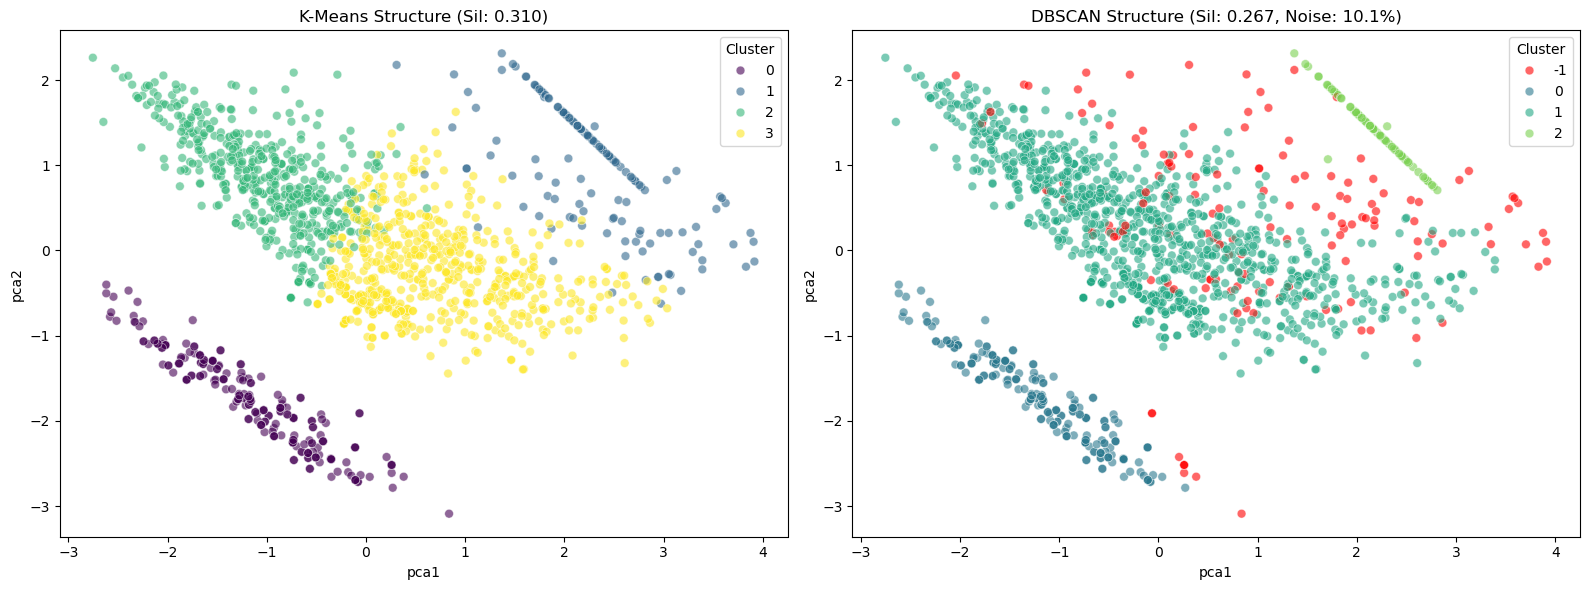

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from IPython.display import display, Markdown

# 1. Calculate Metrics for K-Means
k_labels = df['kmean_cluster']
k_sil = silhouette_score(scaled_data, k_labels)
k_n_clusters = k_labels.nunique()

# 2. Calculate Metrics for DBSCAN
d_labels = df['dbscan_cluster']
# Silhouette for DBSCAN (only if > 1 cluster exist)
if d_labels.nunique() > 1:
    d_sil = silhouette_score(scaled_data, d_labels)
else:
    d_sil = 0

d_noise_pct = (d_labels == -1).mean() * 100
d_n_clusters = d_labels.nunique()

# 3. Create Comparison Table (Structure Focus)
comparison_data = {
    'Metric': [
        'Silhouette Score (Structure Quality)', 
        'Number of Groups', 
        'Noise Percentage (Outliers)'
    ],
    'K-Means': [
        f"{k_sil:.4f}", 
        k_n_clusters, 
        "0.00%"
    ],
    'DBSCAN': [
        f"{d_sil:.4f}", 
        d_n_clusters, 
        f"{d_noise_pct:.2f}%"
    ]
}

df_compare_metrics = pd.DataFrame(comparison_data)

display(Markdown("### Model Structure Comparison"))
display(Markdown("Comparison of clustering structure and data coverage."))
display(df_compare_metrics)

# 4. Visualization (Structure Focus)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: K-Means PCA
sns.scatterplot(data=df, x='pca1', y='pca2', hue='kmean_cluster', palette='viridis', ax=axs[0], s=40, alpha=0.6)
axs[0].set_title(f'K-Means Structure (Sil: {k_sil:.3f})')
axs[0].legend(title='Cluster')

# Plot 2: DBSCAN PCA
u_lab = sorted(d_labels.unique())
# Handle color palette safely
if len(u_lab) > 0:
    pal = {l: 'red' if l == -1 else sns.color_palette("viridis", len(u_lab))[i] for i, l in enumerate(u_lab)}
    sns.scatterplot(data=df, x='pca1', y='pca2', hue='dbscan_cluster', palette=pal, ax=axs[1], s=40, alpha=0.6)
else:
    sns.scatterplot(data=df, x='pca1', y='pca2', ax=axs[1], s=40, alpha=0.6, color='grey')

axs[1].set_title(f'DBSCAN Structure (Sil: {d_sil:.3f}, Noise: {d_noise_pct:.1f}%)')
axs[1].legend(title='Cluster')

plt.tight_layout()
plt.show()

| DBSCAN \ K-Means | **K-Means 1**<br>*(Leader - High Price)* | **K-Means 3**<br>*(Challenger - High Quality)* | **K-Means 2**<br>*(Budget - Low Price)* | **K-Means 0**<br>*(Niche - Isolated)* |
| :--- | :--- | :--- | :--- | :--- |
| **DBSCAN 2**<br>*(Elite - Disciplined)* | **THE DOMINANT CORE**<br>Perfect products: They command huge market share AND adhere to strict linear pricing discipline. These are the true "Kings" of the market. | *(Impossible Intersection)* | *(Impossible Intersection)* | *(Impossible Intersection)* |
| **DBSCAN 1**<br>*(Mass - Standard)* | **STANDARD LEADERS**<br>High-selling products that lack discipline, floating loosely within the chaotic mass cloud. | **DILUTED (1)**<br>High quality but insufficiently distinct to escape the general mass pool (The "Challenger" status is drowned out). | **DILUTED (2)**<br>Budget goods forced to compete directly against premium goods within the same density pool (Substitution threat). | *(Impossible Intersection)* |
| **DBSCAN 0**<br>*(Niche - Passive)* | *(Impossible Intersection)* | *(Impossible Intersection)* | *(Impossible Intersection)* | **ABSOLUTE MATCH**<br>Complete isolation. Both models confirm this group exists on the non-competitive fringe. |
| **DBSCAN -1**<br>*(Noise - Outliers)* | **THE MAVERICKS**<br>Massive success (High Share/Price) achieved by defying standard rules. These are the "Unicorns" hidden by K-Means. | **HIDDEN POTENTIAL**<br>High-quality products with unconventional behavior. A chance to become new Trend-setters. | **JUNK / NOISE**<br>Cheap products behaving erratically, likely data errors or market failures. | **ISOLATED ANOMALIES**<br>Niche products with strange variance. |

In [73]:
#Create Market Archetype Features (Vectorized Optimization)
conditions = [
    (df['kmean_cluster'] == 1) & (df['dbscan_cluster'] == 2),
    (df['kmean_cluster'] == 1) & (df['dbscan_cluster'] == -1),
    (df['kmean_cluster'] == 3) & (df['dbscan_cluster'] == -1),
    (df['kmean_cluster'] == 1) & (df['dbscan_cluster'] == 1),
    (df['kmean_cluster'] == 3) & (df['dbscan_cluster'] == 1),
    (df['kmean_cluster'] == 2) & (df['dbscan_cluster'] == 1),
    (df['kmean_cluster'] == 2) & (df['dbscan_cluster'] == -1),
    (df['kmean_cluster'] == 0) & (df['dbscan_cluster'] == 0)
]
choices = ["Dominant_Core", "Maverick", "Hidden_Potential", "Standard_Leader", "Diluted_Quality", "Diluted_Budget", "Junk_Noise", "Isolated_Niche"]
tiers = [5, 4, 4, 3, 3, 2, 1, 2]

df['Market_Archetype'] = np.select(conditions, choices, default="Other")
df['Archetype_Tier'] = np.select(conditions, tiers, default=2)

# One-Hot Encoding
df = pd.concat([df, pd.get_dummies(df['Market_Archetype'], prefix='Arch')], axis=1)

print("Feature Engineering: Archetypes created.")
display(df[['product_id', 'Market_Archetype', 'Archetype_Tier']].head())

Feature Engineering: Archetypes created.


product_id Market_Archetype  Archetype_Tier
0  B07JW9H4J1   Isolated_Niche               2
1  B098NS6PVG   Isolated_Niche               2
2  B096MSW6CT   Isolated_Niche               2
3  B08HDJ86NZ   Isolated_Niche               2
4  B08CF3B7N1   Isolated_Niche               2

------------------------------------

# 3. Training Predictive Models (Supervised Models)

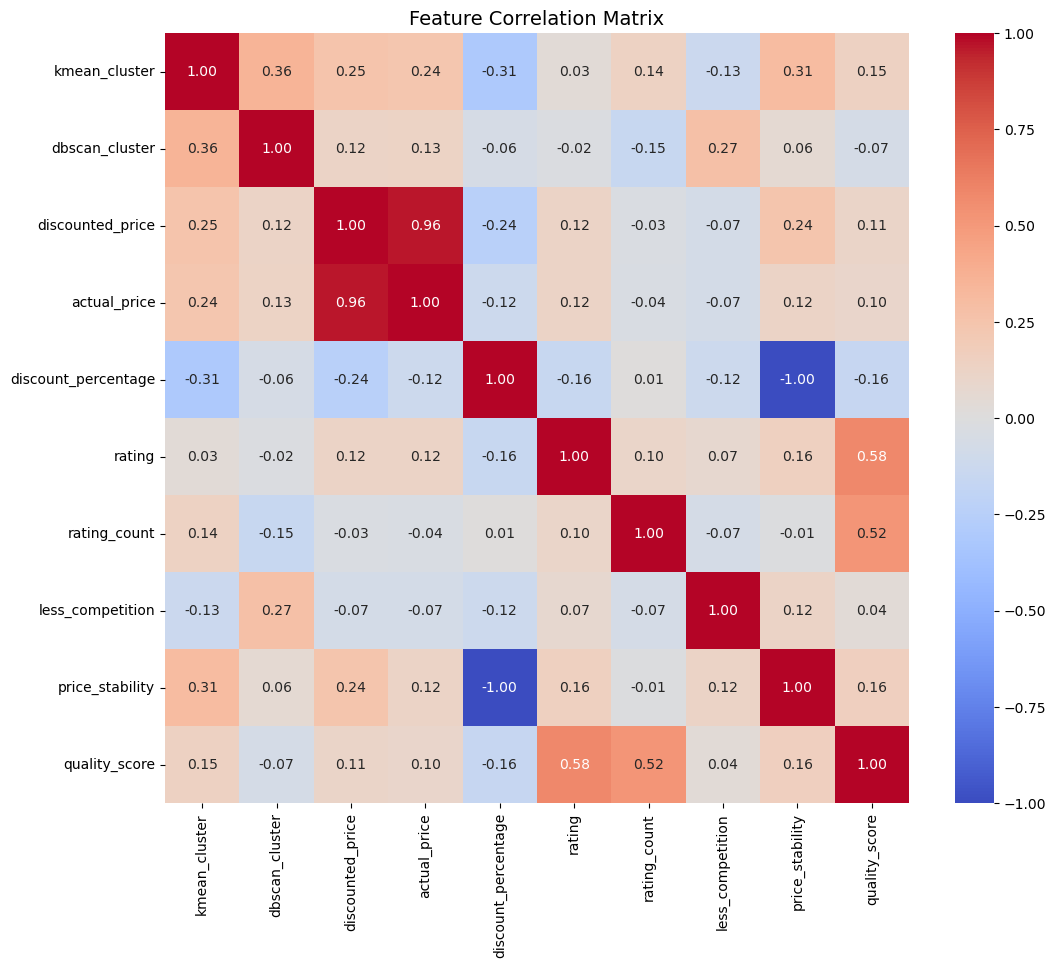

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define features for correlation analysis
correlation_features = [
    'kmean_cluster', 'dbscan_cluster', 'discounted_price', 'actual_price',
    'discount_percentage', 'rating', 'rating_count', 'less_competition',
    'price_stability', 'quality_score'
]

# Calculate and plot correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df[correlation_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix', fontsize=14)
plt.show()

Target Distribution:
investment_potential
Moderate    496
Low         483
High        483
Name: count, dtype: int64

Training Optimized Model with 7 predictive features:
['actual_price', 'discounted_price', 'discount_percentage', 'rating', 'rating_count', 'cat_potential_score', 'price_position_ratio']

Accuracy (Predictive Realism): 0.8178

Classification Report:
              precision    recall  f1-score   support

        High       0.88      0.73      0.80       145
         Low       0.86      0.90      0.88       145
    Moderate       0.73      0.82      0.77       149

    accuracy                           0.82       439
   macro avg       0.83      0.82      0.82       439
weighted avg       0.82      0.82      0.82       439



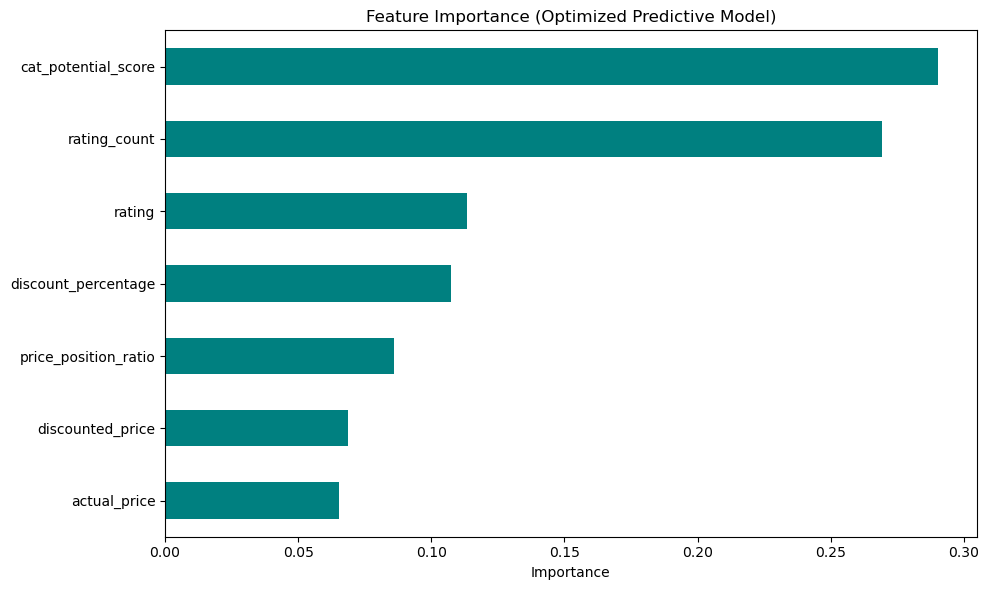

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# 1. Define Target Variable (Investment Potential)
# Normalize investment features to [0, 1] for fair composite scoring
scaler_pot = MinMaxScaler()
df[['less_comp_norm', 'price_stab_norm', 'quality_norm']] = scaler_pot.fit_transform(df[['less_competition', 'price_stability', 'quality_score']])

# Calculate composite investment score (Ground Truth)
# Note: This uses post-launch data (Quality/Stability) to define the LABEL, which is valid.
df['investment_score'] = (
    df['less_comp_norm'] * 0.5 +
    df['price_stab_norm'] * 0.1 +
    df['quality_norm'] * 0.4
)

# Create classes based on percentiles
quantiles = df['investment_score'].quantile([0.33, 0.67])
df['investment_potential'] = pd.cut(
    df['investment_score'],
    bins=[-np.inf, quantiles[0.33], quantiles[0.67], np.inf],
    labels=['Low', 'Moderate', 'High']
)

print(f"Target Distribution:\n{df['investment_potential'].value_counts()}" )

# 2. Advanced Feature Engineering (Solving Data Leakage)
# STRATEGY: We only use features known PRE-LAUNCH. We REMOVE rating/rating_count from input.

# Step 2.1: Prepare Raw Inputs
X_raw = df[['category', 'actual_price', 'discounted_price', 'discount_percentage', 'rating', 'rating_count']].copy()
y = df['investment_potential']
y_score = df['investment_score'] # Used for Target Encoding

# Step 2.2: Split Data FIRST (Crucial to prevent Encoding Leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.3, random_state=42, stratify=y
)

# Align scores for encoding
y_train_score = y_score.loc[X_train.index]

# Step 2.3: Target Encoding for Category
# Logic: "Does this category usually yield high returns?"
cat_potential_map = y_train_score.groupby(X_train['category']).mean()
global_mean_score = y_train_score.mean()

# Apply mapping (Handle new categories in Test set by filling with global mean)
X_train['cat_potential_score'] = X_train['category'].map(cat_potential_map).fillna(global_mean_score)
X_test['cat_potential_score'] = X_test['category'].map(cat_potential_map).fillna(global_mean_score)

# Step 2.4: Price Positioning Feature
# Logic: "Is this product cheaper or more expensive than its competitors?"
cat_price_map = X_train.groupby('category')['discounted_price'].mean()

X_train['cat_avg_price'] = X_train['category'].map(cat_price_map)
X_test['cat_avg_price'] = X_test['category'].map(cat_price_map).fillna(X_train['discounted_price'].mean())

X_train['price_position_ratio'] = X_train['discounted_price'] / X_train['cat_avg_price']
X_test['price_position_ratio'] = X_test['discounted_price'] / X_test['cat_avg_price']

# Final Feature Set (Purely Predictive, No Leakage)
features_final = [
    'actual_price', 
    'discounted_price', 
    'discount_percentage', 
    'rating', 
    'rating_count', 
    'cat_potential_score',   # How good is the category?
    'price_position_ratio'   # Is it a premium or budget item in its list?
]

X_train_final = X_train[features_final]
X_test_final = X_test[features_final]

print(f"\nTraining Optimized Model with {len(features_final)} predictive features:")
print(features_final)

# 3. Model Training (Random Forest with Class Weighting)
le_target = LabelEncoder()
y_train_enc = le_target.fit_transform(y_train)
y_test_enc = le_target.transform(y_test)

rf_model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=12, 
    class_weight='balanced', # Handle potential imbalance
    random_state=42, 
    n_jobs=-1
)
rf_model.fit(X_train_final, y_train_enc)

# 4. Evaluation
y_pred = rf_model.predict(X_test_final)
print(f"\nAccuracy (Predictive Realism): {accuracy_score(y_test_enc, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred, target_names=le_target.classes_))

# 5. Feature Importance
feat_imp = pd.Series(rf_model.feature_importances_, index=features_final).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feat_imp.plot(kind='barh', color='teal')
plt.title('Feature Importance (Optimized Predictive Model)')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 4. Model Testing and Evaluation

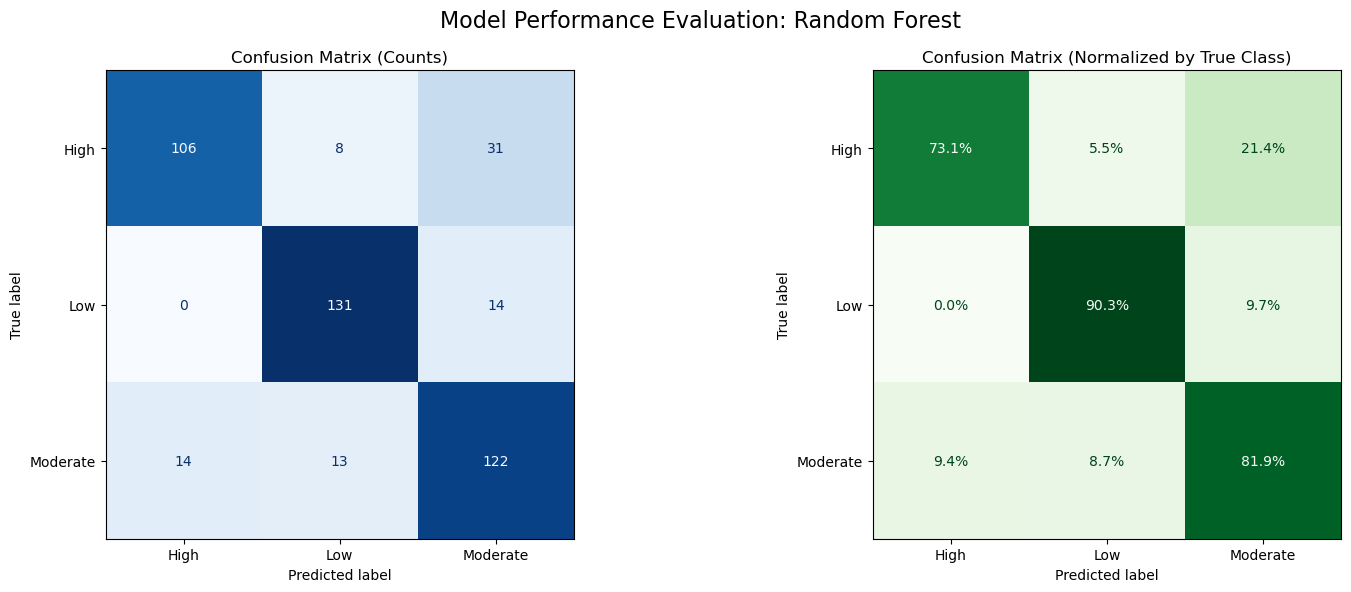

Classification Report Summary:
              precision    recall  f1-score   support

        High       0.88      0.73      0.80       145
         Low       0.86      0.90      0.88       145
    Moderate       0.73      0.82      0.77       149

    accuracy                           0.82       439
   macro avg       0.83      0.82      0.82       439
weighted avg       0.82      0.82      0.82       439



In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

# 1. Prepare Data
y_test_encoded = le_target.transform(y_test)

# 2. Create Plot Area (Side-by-Side)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 3. Plot 1: Raw Counts
cm = confusion_matrix(y_test_encoded, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_target.classes_)
disp.plot(cmap='Blues', ax=axes[0], colorbar=False)
axes[0].set_title('Confusion Matrix (Counts)')

# 4. Plot 2: Normalized (%)
# Normalize by true labels (rows)
cm_norm = confusion_matrix(y_test_encoded, y_pred, normalize='true')
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=le_target.classes_)
disp_norm.plot(cmap='Greens', ax=axes[1], values_format='.1%', colorbar=False)
axes[1].set_title('Confusion Matrix (Normalized by True Class)')

plt.suptitle('Model Performance Evaluation: Random Forest', fontsize=16)
plt.tight_layout()
plt.show()

# Print text report for completeness
print("Classification Report Summary:")
print(classification_report(y_test_encoded, y_pred, target_names=le_target.classes_))


In [77]:
# 2. Functions for Manual Testing & Growth Simulation
from IPython.display import display, Markdown

def get_prediction_details(actual_price, discounted_price, discount_percentage, rating, rating_count, category_name):
    """Core prediction logic returning dictionary with full details"""
    # 1. Feature lookup
    cat_score = cat_potential_map.get(category_name, global_mean_score)
    cat_avg_price = cat_price_map.get(category_name, X_train['discounted_price'].mean())
    
    # 2. Construct input
    input_data = pd.DataFrame([{
        'actual_price': actual_price,
        'discounted_price': discounted_price, 
        'discount_percentage': discount_percentage,
        'rating': rating,
        'rating_count': rating_count,
        'cat_potential_score': cat_score,
        'price_position_ratio': discounted_price / cat_avg_price
    }])
    
    # 3. Predict
    pred_label = le_target.inverse_transform(rf_model.predict(input_data))[0]
    probs = rf_model.predict_proba(input_data)[0]
    
    # Map probabilities to classes
    prob_dict = {label: prob for label, prob in zip(le_target.classes_, probs)}
    
    return {
        "Prediction": pred_label,
        "Probabilities": prob_dict,
        "Input_Features": input_data.iloc[0].to_dict()
    }

def visualize_product_test(actual_price, discounted_price, discount_percentage, rating, rating_count, category_name):
    """User-friendly wrapper to test a single product scenario"""
    result = get_prediction_details(actual_price, discounted_price, discount_percentage, rating, rating_count, category_name)
    
    # Visual Output using Markdown/Print
    print("\n" + "="*60)
    print(f" PRODUCT POTENTIAL ANALYSIS ".center(60))
    print("="*60)
    print(f"Category: {category_name.split('|')[-1]}") # Shorten category for display
    print(f"Price: Rs. {discounted_price} (MRP: Rs. {actual_price} | -{discount_percentage}%)")
    print(f"Rating: {rating} / 5.0 ({rating_count} reviews)")
    print("-" * 60)
    
    # Visualizing Prediction
    pred = result['Prediction']
    color_map = {'High': '[HIGH]', 'Moderate': '[MOD]', 'Low': '[LOW]'}
    icon = color_map.get(pred, '[N/A]')
    
    print(f"PREDICTION: {icon} {pred.upper()} POTENTIAL")
    
    # Visualizing Probabilities
    print("\nConfidence Levels:")
    for label, prob in result['Probabilities'].items():
        bar_len = int(prob * 25)
        bar = "█" * bar_len + "░" * (25 - bar_len)
        print(f"   {label:<10} |{bar}| {prob:.1%}")
    print("="*60 + "\n")

def simulate_growth_path(actual_price, discounted_price, discount_percentage, rating, current_reviews, category_name, step=100, max_reviews=10000):
    """Simulates how many reviews are needed to reach 'High' potential"""
    
    print(f"\n>>> STARTING GROWTH SIMULATION: Aiming for 'High' Potential...")
    print(f"   (Base Reviews: {current_reviews} | Step: +{step})")
    
    # Initial Check
    initial_res = get_prediction_details(actual_price, discounted_price, discount_percentage, rating, current_reviews, category_name)
    high_prob_initial = initial_res['Probabilities'].get('High', 0)
    
    if initial_res['Prediction'] == 'High':
        print(f"\n[OK] Product is ALREADY classified as HIGH potential (Confidence: {high_prob_initial:.1%}).")
        return

    # Simulation
    history = []
    found_success = False
    
    # Add initial state
    history.append({
        'Total Reviews': current_reviews, 
        'Added Reviews': 0,
        'High_Prob': high_prob_initial, 
        'Status': initial_res['Prediction']
    })

    for sim_reviews in range(current_reviews + step, max_reviews + 1, step):
        res = get_prediction_details(actual_price, discounted_price, discount_percentage, rating, sim_reviews, category_name)
        prob_high = res['Probabilities'].get('High', 0)
        
        # Log logic: Log if status changes or periodically
        if res['Prediction'] != history[-1]['Status'] or sim_reviews % (step * 5) == 0:
             history.append({
                'Total Reviews': sim_reviews, 
                'Added Reviews': sim_reviews - current_reviews,
                'High_Prob': prob_high, 
                'Status': res['Prediction']
            })
        
        if res['Prediction'] == 'High':
            found_success = True
            history.append({
                'Total Reviews': sim_reviews, 
                'Added Reviews': sim_reviews - current_reviews,
                'High_Prob': prob_high, 
                'Status': res['Prediction']
            }) # Ensure final success state is captured
            
            needed = sim_reviews - current_reviews
            print(f"\n[SUCCESS] Reached 'High' potential at {sim_reviews} reviews.")
            print(f"   (Required +{needed} new reviews)")
            break

    if not found_success:
        print(f"\n[FAILED] Reached max limit ({max_reviews} reviews) without hitting 'High'.")
        print("   Consider improving Product Rating or adjusting Pricing Strategy.")

    # Visualize Trajectory Table
    if history:
        df_hist = pd.DataFrame(history).drop_duplicates(subset=['Total Reviews'])
        print("\nGrowth Trajectory Snapshot:")
        # Display as a clean text table
        print(df_hist.to_string(index=False, formatters={'High_Prob': '{:.1%}'.format}))

# Example Usage
print("--- TEST CASE 1: MANUAL CHECK ---")
visualize_product_test(
    actual_price=120, discounted_price=60, discount_percentage=50, 
    rating=4.2, rating_count=100, 
    category_name="Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables"
)

print("--- TEST CASE 2: GROWTH SIMULATION ---")
simulate_growth_path(
    actual_price=120, discounted_price=60, discount_percentage=50, 
    rating=4.2, current_reviews=100, 
    category_name="Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables"
)


--- TEST CASE 1: MANUAL CHECK ---

                 PRODUCT POTENTIAL ANALYSIS                 
Category: USBCables
Price: Rs. 60 (MRP: Rs. 120 | -50%)
Rating: 4.2 / 5.0 (100 reviews)
------------------------------------------------------------
PREDICTION: [LOW] LOW POTENTIAL

Confidence Levels:
   High       |█░░░░░░░░░░░░░░░░░░░░░░░░| 6.5%
   Low        |███████████████░░░░░░░░░░| 63.0%
   Moderate   |███████░░░░░░░░░░░░░░░░░░| 30.5%

--- TEST CASE 2: GROWTH SIMULATION ---

>>> STARTING GROWTH SIMULATION: Aiming for 'High' Potential...
   (Base Reviews: 100 | Step: +100)

[FAILED] Reached max limit (10000 reviews) without hitting 'High'.
   Consider improving Product Rating or adjusting Pricing Strategy.

Growth Trajectory Snapshot:
 Total Reviews  Added Reviews High_Prob Status
           100              0      6.5%    Low
           500            400      7.0%    Low
          1000            900      8.0%    Low
          1500           1400     11.0%    Low
          2000      

In [78]:
# Example usage: Deep Dive with Scenarios
print("--- Scenario 1: Low Rating (3.5), Low Reviews (50) ---")
simulate_growth_path(
    actual_price=1000, discounted_price=500, discount_percentage=50, 
    rating=3.5, current_reviews=50, 
    category_name="Electronics|HomeAudio|Speakers"
)

print("\n--- Scenario 2: Good Rating (4.5), Need Volume ---")
simulate_growth_path(
    actual_price=1000, discounted_price=500, discount_percentage=50, 
    rating=4.5, current_reviews=50, 
    category_name="Electronics|HomeAudio|Speakers"
)

--- Scenario 1: Low Rating (3.5), Low Reviews (50) ---

>>> STARTING GROWTH SIMULATION: Aiming for 'High' Potential...
   (Base Reviews: 50 | Step: +100)

[FAILED] Reached max limit (10000 reviews) without hitting 'High'.
   Consider improving Product Rating or adjusting Pricing Strategy.

Growth Trajectory Snapshot:
 Total Reviews  Added Reviews High_Prob   Status
            50              0      1.5%      Low
          1750           1700      3.0% Moderate

--- Scenario 2: Good Rating (4.5), Need Volume ---

>>> STARTING GROWTH SIMULATION: Aiming for 'High' Potential...
   (Base Reviews: 50 | Step: +100)

[SUCCESS] Reached 'High' potential at 4450 reviews.
   (Required +4400 new reviews)

Growth Trajectory Snapshot:
 Total Reviews  Added Reviews High_Prob   Status
            50              0      4.6%      Low
           650            600      7.1% Moderate
          4450           4400     43.9%     High


In [79]:
# 3. Compare Actual vs Predicted for Random Samples
test_indices = X_test.index
random_indices = np.random.choice(test_indices, 5, replace=False)
comparison_df = df.loc[random_indices].copy()
comparison_df['Actual_Potential'] = y[random_indices]
comparison_df['Predicted_Potential'] = le_target.inverse_transform(rf_model.predict(X_test_final.loc[random_indices]))

print("\n--- Random Samples Evaluation: Actual vs Predicted ---")
display(comparison_df[['category', 'actual_price', 'rating', 'Actual_Potential', 'Predicted_Potential']])


--- Random Samples Evaluation: Actual vs Predicted ---


category  actual_price  rating  \
700   Computers&Accessories|Accessories&Peripherals|...        1799.0     4.5   
813   Electronics|Headphones,Earbuds&Accessories|Hea...        1499.0     3.6   
642   Computers&Accessories|Accessories&Peripherals|...        1000.0     3.9   
1061  Home&Kitchen|Kitchen&HomeAppliances|Vacuum,Cle...        1695.0     4.4   
1080  Home&Kitchen|Heating,Cooling&AirQuality|RoomHe...        1989.0     4.3   

     Actual_Potential Predicted_Potential  
700               Low                 Low  
813               Low                 Low  
642               Low                 Low  
1061         Moderate            Moderate  
1080              Low                 Low

## 5. Final Investment Recommendation

In [80]:
# Load original data to get names
try:
    df_orig = pd.read_csv('amazon.csv', usecols=['product_id', 'product_name'])
    df_final = df.merge(df_orig, on='product_id', how='left')
except FileNotFoundError:
    df_final = df.copy()
    df_final['product_name'] = "Name Not Available"

# Filter High Potential
high_potential_df = df_final[df_final['investment_potential'] == 'High'].copy()

# Sort by Score
high_potential_df = high_potential_df.sort_values(by='investment_score', ascending=False)

print("============================================================")
print("       FINAL INVESTMENT RECOMMENDATION REPORT")
print("============================================================\n")

print(f"Total 'High' Potential Products Found: {len(high_potential_df)}")

print("\n>>> TOP 10 PRODUCTS TO INVEST IN (Highest Score):")
display(high_potential_df[['product_id', 'product_name', 'category', 'discounted_price', 'rating', 'investment_score']].head(10))

print("\n>>> TOP 5 CATEGORIES WITH MOST OPPORTUNITIES:")
top_cats = high_potential_df['category'].value_counts().head(5).reset_index()
top_cats.columns = ['Category', 'High_Potential_Count']
display(top_cats)

# Strategic Insight
print("\n>>> STRATEGIC INSIGHT:")
print("- Focus on the 'Challengers' (Cluster 3) identified in the analysis.")
print("- These products have high quality but currently lack market share.")
print("- Recommended Action: Increase visibility through marketing (ads/promotions) to convert quality into sales.")

       FINAL INVESTMENT RECOMMENDATION REPORT

Total 'High' Potential Products Found: 529

>>> TOP 10 PRODUCTS TO INVEST IN (Highest Score):


product_id                                       product_name  \
1224  B0083T231O  Belkin Essential Series 4-Socket Surge Protect...   
893   B098K3H92Z  TP-Link USB Bluetooth Adapter for PC, 5.0 Blue...   
1013  B08GYG6T12  SanDisk Ultra SDHC UHS-I Card 32GB 120MB/s R f...   
1243  B00LY12TH6  Camel Oil Pastel with Reusable Plastic Box - 5...   
957   B0752LL57V  Casio MJ-12D 150 Steps Check and Correct Deskt...   
1169  B00DJ5N9VK  Faber-Castell Connector Pen Set - Pack of 25 (...   
1184  B08FYB5HHK  TP-Link UE300C USB Type-C to RJ45 Gigabit Ethe...   
999   B08C4Z69LN  Crucial RAM 8GB DDR4 3200MHz CL22 (or 2933MHz ...   
1136  B07JB2Y4SR  Classmate Octane Colour Burst-Multicolour Gel ...   
912   B00R1P3B4O  Fujifilm Instax Mini Single Pack 10 Sheets Ins...   

                                               category  discounted_price  \
1224       Electronics|PowerAccessories|SurgeProtectors            1289.0   
893   Computers&Accessories|NetworkingDevices|Networ...             599.0   
1013  Electronics|Accessories|MemoryCards|SecureDigi...             449.0   
1243      Home&Kitchen|CraftMaterials|PaintingMaterials             230.0   
957   OfficeProducts|OfficeElectronics|Calculators|B...             440.0   
1169  Toys&Games|Arts&Crafts|Drawing&PaintingSupplie...             150.0   
1184  Computers&Accessories|NetworkingDevices|Networ...            1199.0   
999             Computers&Accessories|Components|Memory            1792.0   
1136  Home&Kitchen|CraftMaterials|DrawingMaterials|D...              90.0   
912    Electronics|Cameras&Photography|Accessories|Film             549.0   

      rating  investment_score  
1224     4.5          0.904359  
893      4.3          0.901561  
1013     4.4          0.896221  
1243     4.5          0.893469  
957      4.5          0.890492  
1169     4.3          0.882958  
1184     4.5          0.879372  
999      4.5          0.874907  
1136     4.4          0.873650  
912      4.5          0.871811


>>> TOP 5 CATEGORIES WITH MOST OPPORTUNITIES:


Category  High_Potential_Count
0  Computers&Accessories|Accessories&Peripherals|...                    41
1  Electronics|Headphones,Earbuds&Accessories|Hea...                    15
2        Electronics|Accessories|MemoryCards|MicroSD                    15
3  Electronics|Mobiles&Accessories|Smartphones&Ba...                    13
4  Computers&Accessories|NetworkingDevices|Networ...                    10


>>> STRATEGIC INSIGHT:
- Focus on the 'Challengers' (Cluster 3) identified in the analysis.
- These products have high quality but currently lack market share.
- Recommended Action: Increase visibility through marketing (ads/promotions) to convert quality into sales.
